## 0. Required dependencies ##
You'll need recent versions of jupyter (but if you're reading this, you are probably OK), opencv-python (and probably opencv-contrib-python), tqdm, scikit-learn, numpy, pandas and matplotlib. I've included a requirements.txt file for your convenience, but I basically use the most recent versions of everything, and the code works.

I advise you to use a form of virtual environments to manage your python projects (e.g. pipenv, venv, conda etc.).

To get free GPU time, you can try Google Colab. It is a tool for running notebooks, and provides you with a VM and a GPU for free! Most of the recent packages used in ML are automatically installed, so that is also nice.

In [1]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features


#Will this be the absolute winner?
import xgboost as xgb

# tell matplotlib that we plot in a notebook
%matplotlib notebook

In [2]:
# filepath constants, set these according to your workflow:

# where are your datasets:
dataset_path = 'datasets'
# where do you want to save your features and other outputs:
output_path = 'predictions'

In [3]:
# you don't have to change the paths here:

dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

## 1. Loading the data and the labels
First, let's get the training labels. The train data is ordered in a way such that all images in a class are stored in a separate folder, thus we can simply get a string represenation of the labels by using the folder names.

In [4]:
folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]

print("Amount of classes: ", num_classes)
print("\nLabels: \n", label_strings)

Amount of classes:  12

Labels: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


Since loading all images of the train set into memory at once is hardly feasible, we simply collect all their filepaths and load them on demand. Therefore, we build a dictionary of the filepaths to all our train images, sorted by label. We do the same for our test images.

In [5]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

Let's take a look at a few examples of each class. We start by loading and displaying the first image of the 'tiger' class. Images loaded using OpenCV can be displayed using pyplot. One has to mind conventions: while using OpenCV, image channels are stored in the order blue-green-red, but pyplot assumes images to be stored in the more common RGB format. Luckily OpenCV's <code>cvtColor</code> method enables straight-forward conversion between the formats:

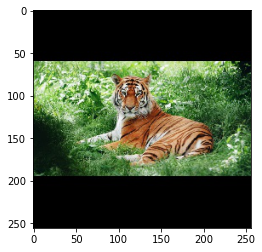

In [6]:
# load first image of class bobcat using opencv:
image = cv2.imread(train_paths['tiger'][0])

# images can be plotted using matplotlib, but need to be converted from BGR to RGB
%matplotlib inline
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

Alright, let's see if we can learn more about how the different color channels are aligned in a numpy array which holds the image data. We'll plot each color channel individually:

Image shape: (256, 256, 3)


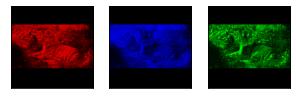

In [7]:
# blue, green and red channels are aligned along the third dimension of the returned numpy array
print('Image shape: {}'.format(image.shape))


# compute aspect ratio of image 
(height, width, nr_channels) = image.shape

aspect_ratio = width / float(height)

fig_height = 5

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(fig_height * aspect_ratio, fig_height))
[ax.get_xaxis().set_visible(False) for ax in axes]
[ax.get_yaxis().set_visible(False) for ax in axes]
ax0, ax1, ax2 = axes

# extract blue, green and red channels from image
blue_channel = image[:, :, 0]
green_channel = image[:, :, 1]
red_channel = image[:, :, 2]

ax0.imshow(np.dstack([red_channel, np.zeros_like(blue_channel), np.zeros_like(blue_channel)]))
ax1.imshow(np.dstack([np.zeros_like(green_channel), np.zeros_like(green_channel), green_channel]))
ax2.imshow(np.dstack([np.zeros_like(red_channel), blue_channel, np.zeros_like(red_channel)]))

plt.show()

## 2. Looking at the data
As we are warmed up now, we plot the first 3 images of each class to get a first impression on what our data looks like.

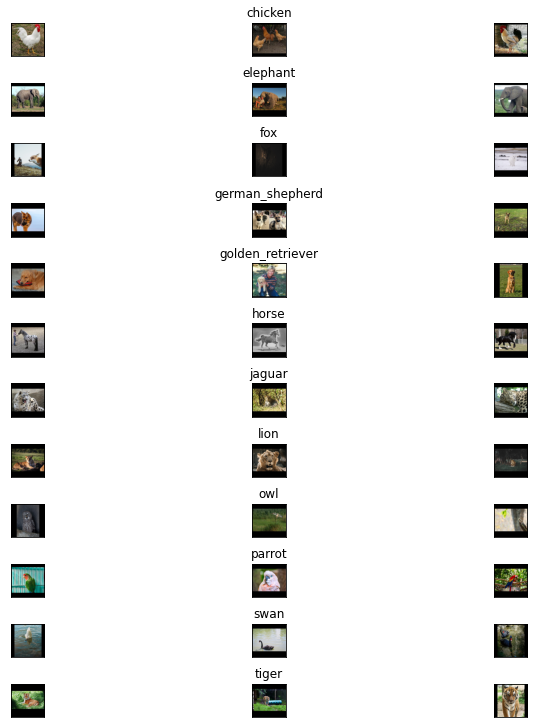

In [8]:
fig, axes = plt.subplots(nrows=num_classes, ncols=3, constrained_layout=True, figsize=(10, 10))

[ax.get_xaxis().set_visible(False) for ax_row in axes for ax in ax_row]
[ax.get_yaxis().set_visible(False) for ax_row in axes for ax in ax_row]

for idx, label_string in enumerate(label_strings):
    images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in train_paths[label_string][:3]]

    for colidx in range(3):
        axes[idx, colidx].imshow(images[colidx])
        if colidx == 1: # if this is the center column
            axes[idx, colidx].set_title(label_string)

plt.show()    

We can see that the images are quite diverse and vary in scale, viewpoint etc. This means that we will have to be careful to use the right feature descriptors in the feature extraction stage. We would prefer features which show a certain kind of invariance to this diversity. The dataset has been scraped from the web, which means that we can expect some degree of label noise as well.

## 2. The Bag-Of-Visual-Words model

The concept of a bag-of-words (BoW) model originates from the field of Natural Language Processing (NLP). In NLP problems, the input is text. However, for a machine learning model, we need numerical features as input. One way to translate text to features is to use part of its natural structure: the grouping of characters into words. To construct a BoW-model, you do the following (with possible fine-tunings for each step):

* Make a histogram of all the words in the text, throw out words that are not important (e.g., typos, words in another language, short words like 'the', 'an', 'of', ...) and possibly group similar words (e.g., conjugations of the same verb, synonyms ...).
* Keep the k most frequently occurring words (with k a hyperparameter).
* For each document, make a (k x 1) vector for which the i-th value corresponds to the number of times the i-th word occurs in that document.
* Additionally, or as an alternative, you can also make binary vectors (only recording whether or not a word occurs in a document, not how frequently).

This gives you long but sparse feature vectors that you can use in a machine learning model.

In a visual BoW, we do something similar for images. The problem is that there aren't any 'words' naturally available. Instead, we want to look for 'typical local structures' in the image (e.g. small significant areas or patches). Obviously, this shifts the problem to defining what 'typical patches' are. Luckily, there exist a range of feature extractors in image processing that detect those interesting patches. What this means exactly depends on the specific feature type, but these patches (or transformed representations of those) can be used to construct a dictionary for images. How this is done exactly is explained in more detail in the 'creating_vbow' notebook on this topic. It basically boils down to the following:

* We extract the chosen type of features for all the images in the training set (the maximal number is upper bounded by a hyperparameter).
* Accross this huge set of patches, we cluster similar patches together into a set number of classes (another hyperparameter, which sets the number of BoW features), and compute the 'average patch' for each cluster -- these are the visual 'words'.
* We then encode each image (from train set or test set) in a similar way to the BoW model: we assign each extracted patch to a cluster (word) and count how many times each cluster occurs in each image.

For the competition, the focus lies on correctly applying and implementing the standard machine learning flow. In order to get you started, we have implemented a simple version of this BoW procedure for you. As a first step, we advise you to simply use that and focus on everything else. If you want to aim for excellent scores, you can try improving this simple VBoW approach by tuning the extraction yourself. Note that this uses k-means clustering, a very commmon unsupervised technique for clustering. You can find a lot of information on this technique on the web.

In what follows, we only show you how to use the code provided by us. For the details of the code itself, we refer to the second notebook and the code in the 'features' file.

## 3. Using the provided image features

Download the feature files provided on the Kaggle competition site. These contain raw image features before the creation of clusters and the counting of the visual words. You can also re-extract them yourself using the code in the 'creating_vbow' notebook, or extract other kinds of features there.

In what follows, we simply load the extracted features from disk. They are stored as pickle files, which are just files serialized for python.

In this case, we'll use the freak features provided to you. But definitely read the creating_vbow notebook and take a look at the other features, it could inspire you to try new things.

In [9]:
descriptor_desired = 'surf'


In [10]:
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)
    
print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))



Number of encoded train images: 4042


In [11]:
with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)
        
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))



Number of encoded test images: 4035


The next thing we need to do is to cluster the training features into the words that will construct our dictionary. You are NOT allowed to use features from the test images to do this. Even if you did use the test images, it would not improve your final performance, since you are overfitting your model on the test set, which is an error you have to avoid at all times. In addition, when using validation or cross-validation, the validation set should also not be used here. Think about your clustering and your train/test/validations splits, and how you will avoid information leakage here...

Note that the number of categories (words) is a hyperparameter that should be optimised, ideally with grid search, but you can also try it manually. For this starting example, we give it a try with <code>codebook_size=500</code>. 

The functions we use below are implemented in the 'helpers' library. Our kind thanks go out to the authors of [https://github.com/flytxtds/scene-recognition](https://github.com/flytxtds/scene-recognition), from where this code has been adapted. 

The code below creates the desired encoded BoW feature vector.

**Important note:** if you were to encounter an error, similar to 'ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index X has 0 dimension(s)', or: 'ValueError: Expected 2D array, got scalar array instead: array=nan.', this is because your feature descriptor has found no patches on a certain image. If this is in your training set, you can simply remove this image and recreate your features. You can find the image for the former error by printing

    train_features_from_pkl[X] 

(with X the index from your error message), or for the latter error with

    for i, img in enumerate(train_features_from_pkl):
        try:
            _ = len(img.data)
        except ValueError as e:
            print(img)

Let me know what image it was, and I'll update the dataset on Kaggle for the others. It is especially important to let me know if this error occurred in the test set, since otherwise you won't be able to submit a good submission. You can send an e-mail to andries.rosseau@vub.be.

In [85]:
# learn the codebook for the 'freak' features from the training data

codebook_size = 2400

clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)



training took 1830.4371728897095 seconds


In [86]:
# encode all train images 
train_data = []
train_labels = []



for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)
    


In [87]:
# encode all test images 
test_data = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)

Now that we have readily useable train and test data matrices, there is only one thing missing: our label vector still contains string representations of our labels, but in order to train a supervised classifier, we need the labels to be represented as integers of course. The <code>LabelEncoder</code> class of sklearn does exactly that.

In [88]:
# use a labelencoder to obtain numerical labels
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
print(train_labels[:10])
train_labels = label_encoder.transform(train_labels)





['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']


We now have feature vectors with hopefully meaningful BOVW representations, as well as a train label vector in the right format. We are all set to start and train a supervised model on our data, do feature selection, model evaluation etc. This is where you come in, of course. As a last step, we will show how to generate a sample submission for the competition homepage using a 'prior probability algorithm', which simply outputs the prior probabilities of the classes.

## 4. Making a submission
For our naive sample submission we just count the amount of training samples per class, and divide them by the total amount of samples to get our output probabilities for every test sample. <code>helpers.writePredictionsToCsv</code> can be used to write out predictions as a csv file ready to be submitted to the competition page.

In [89]:
# Compute a naive prediction
prior_predictions = np.array([len(train_paths[label]) for label in label_strings])
prior_predictions = prior_predictions / np.sum(prior_predictions)
print(prior_predictions)

prior_predictions = np.tile(prior_predictions, (len(test_paths), 1))

[0.13607125 0.10761999 0.06160317 0.11429985 0.01855517 0.11528946
 0.021524   0.0974765  0.07941613 0.10044532 0.05294409 0.09475507]


## Data exploration

In [ ]:
# Load distribution of training/testing image sizes
train_shapes = []
test_shapes = []
for i in range(len(train_imgs)):
    img_id = train_ids[i]
    img_path = os.path.join(train_dir, img_id, "images", train_imgs[img_id])
    train_shapes.append(load_img_shapes(img_path))
for i in range(len(test_imgs)):
    img_id = test_ids[i]
    img_path = os.path.join(test_dir, img_id, "images", test_imgs[img_id])
    test_shapes.append(load_img_shapes(img_path))

df_train = pd.DataFrame({'Shapes': train_shapes})
train_counts = df_train['Shapes'].value_counts()
df_test = pd.DataFrame({'Shapes': test_shapes})
test_counts = df_test['Shapes'].value_counts()
print("Training Image Shapes:")
for i in range(len(train_counts)):
    print("Shape %s counts: %d" % (train_counts.index[i], train_counts.values[i]))
print("*"*50)
print("Testing Image Shapes:")
for i in range(len(test_counts)):
    print("Shape %s counts: %d" % (test_counts.index[i], test_counts.values[i]))
    
    
# Plot distribution of train/test image shapes
plt.figure(figsize=(14, 10))
sns.barplot(x=train_counts.index, y=train_counts.values)
plt.title("Train Dataset")

plt.figure(figsize=(14, 10))
sns.barplot(x=test_counts.index, y=test_counts.values)
plt.title("Test Dataset")

plt.show()

### Data distribution

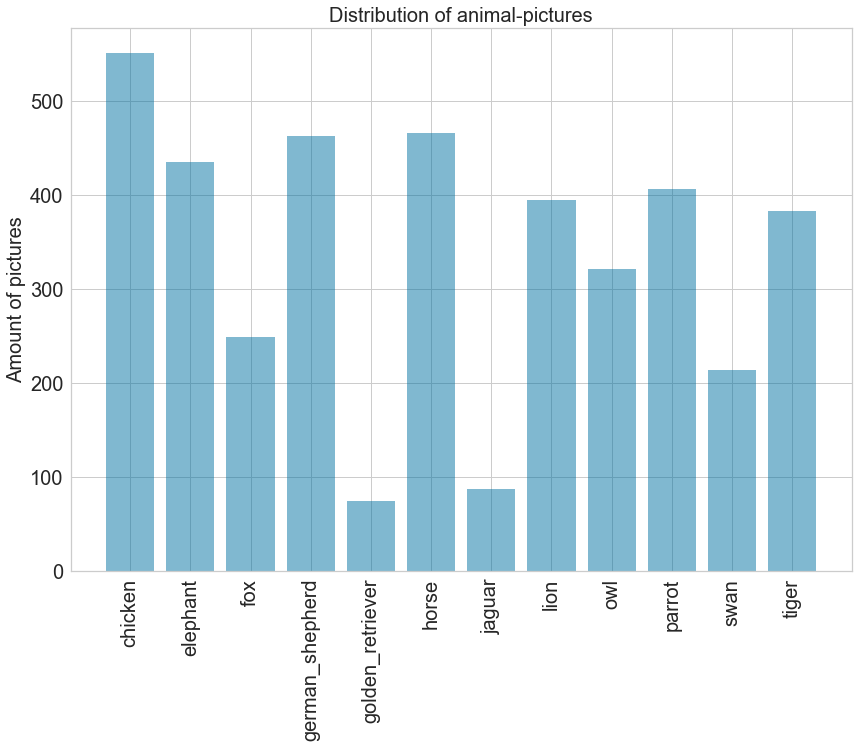

In [70]:
animals_per_species = []
y_pos = []
for label_string in label_strings:
    animals_per_species.append(len(train_paths[label_string]))
    y_pos.append(label_string)



plt.figure(figsize=(14, 10))
plt.bar(y_pos, animals_per_species, align='center', alpha=0.5 )
plt.xticks(y_pos, rotation='vertical', fontsize=20)
plt.yticks(fontsize=20)

plt.ylabel('Amount of pictures' , fontsize=20)
plt.title('Distribution of animal-pictures' , fontsize=20)

plt.show()

Submitting the csv file generated should give you a public leaderboard score of about 2.36. It's up to you now to build a classifier that at least beats these prior scores (and then keep improving of course). Good luck competing!

### Data correlation matrix

(4042, 3000)


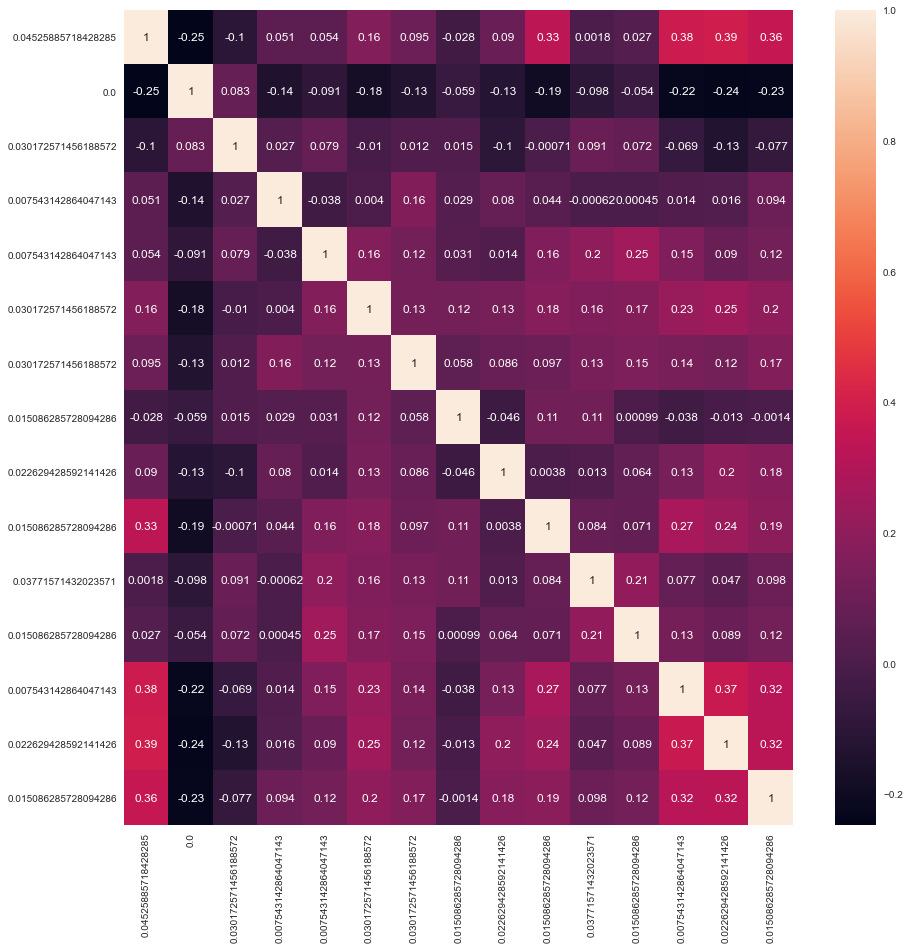

In [78]:
import pandas as pd
import seaborn as sns
X = train_data
Y = train_labels

df = pd.DataFrame(X, columns = X[0])

print(df.shape)

df_small = df.iloc[:,:15]
correlation_mat = df_small.corr()


plt.figure(figsize=(15, 15))
sns.heatmap(correlation_mat, annot = True , annot_kws={"size":12} )

plt.show()
#as we a can see there is a very low correlation between features

## Data preprocessing

### Feature selection using chi squared test

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 , mutual_info_classif , f_classif
X = train_data
Y = train_labels

---------------2.0758942978019133
this is the featuresize: 20
this is the best score: 2.0758942978019133
---------------2.036020944490651
this is the featuresize: 40
this is the best score: 2.036020944490651
---------------1.9433447314384271
this is the featuresize: 60
this is the best score: 1.9433447314384271
---------------1.863470554313419
this is the featuresize: 80
this is the best score: 1.863470554313419
---------------1.804843365951788
this is the featuresize: 100
this is the best score: 1.804843365951788
---------------1.7374915766305077
this is the featuresize: 120
this is the best score: 1.7374915766305077
---------------1.7530476004540458
---------------1.6855596860395783
this is the featuresize: 160
this is the best score: 1.6855596860395783
---------------1.679896710302406
this is the featuresize: 180
this is the best score: 1.679896710302406
---------------1.615440283563744
this is the featuresize: 200
this is the best score: 1.615440283563744
---------------1.615593610

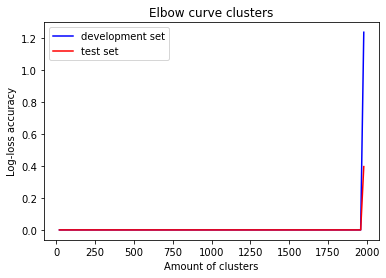

In [28]:

def plot_feature_selection_graph(X, Y, minimum, maximum , step):
    best_score = 99999999
    idx = 0
    for k_param in range (minimum,len(X[0]),step):
        X = train_data
        Y = train_labels
        amount_of_zeroes = (maximum-minimum) // step
        DEV_errors = np.zeros(amount_of_zeroes)
        X_errors = np.zeros(amount_of_zeroes)
        X = SelectKBest(mutual_info_classif, k =  k_param).fit_transform(X,Y)
        X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!  
        logreg_best = LogisticRegression(C = 10 , penalty = 'l2' , max_iter= 2000 )
        logreg_best.fit(X,Y)
        logistic_regression_dev = logreg_best.predict_proba(X_DEV)
        acc_logreg_dev = log_loss(Y_DEV, logistic_regression_dev)
        logistic_regression_test = logreg_best.predict_proba(X)
        acc_logreg_test = log_loss(Y, logistic_regression_test)
        DEV_errors[idx] = acc_logreg_dev
        X_errors[idx]=acc_logreg_test
        print("---------------" + str(acc_logreg_dev))
        if acc_logreg_dev < best_score:
                best_score = acc_logreg_dev
                print("this is the featuresize: " + str(k_param))
                print("this is the best score: " + str(best_score))

        idx = idx + 1


    plt.figure()
    plt.plot(np.arange(minimum,maximum,step),DEV_errors,c='b',label='development set')
    plt.plot(np.arange(minimum,maximum,step),X_errors,c='r',label='test set')
    plt.xlabel("Amount of clusters")
    plt.ylabel("Log-loss accuracy")
    plt.title("Elbow curve clusters")
    plt.legend()
    plt.show()
plot_feature_selection_graph(train_data, train_labels, 20,2000, 20)
    
    

Finding the elbow for the clustering (using logreg)

---------------1.9023708421216021
this is the featuresize: 20
this is the best score: 1.9023708421216021
---------------1.8341670200081506
this is the featuresize: 40
this is the best score: 1.8341670200081506
---------------1.7625984719376269
this is the featuresize: 60
this is the best score: 1.7625984719376269
---------------1.6689922408931723
this is the featuresize: 80
this is the best score: 1.6689922408931723
---------------1.6278254712178113
this is the featuresize: 100
this is the best score: 1.6278254712178113
---------------1.5903609997202688
this is the featuresize: 120
this is the best score: 1.5903609997202688
---------------1.5614394014739486
this is the featuresize: 140
this is the best score: 1.5614394014739486
---------------1.5361576853337744
this is the featuresize: 160
this is the best score: 1.5361576853337744
---------------1.512963144478785
this is the featuresize: 180
this is the best score: 1.512963144478785
---------------1.5025397808171206
this is the featur

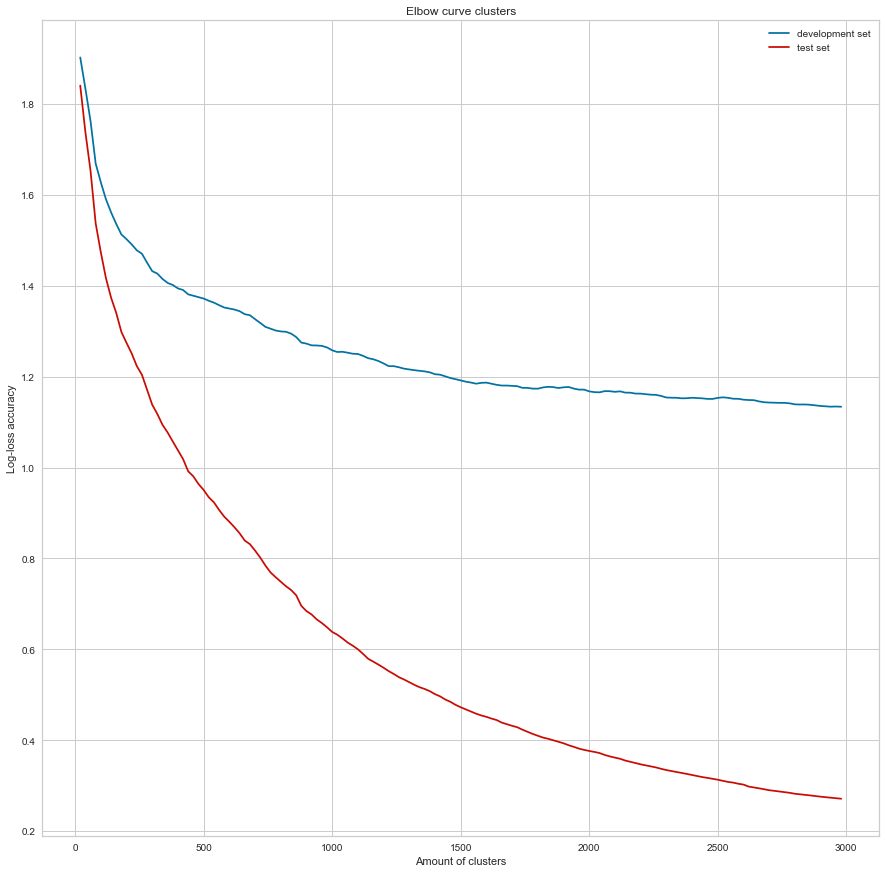

1.1338691372841232

In [84]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 , mutual_info_classif , f_classif
X = train_data
Y = train_labels
def plot_feature_selection_graph_anova(X, Y, minimum, maximum , step):
    best_score = 99999999
    idx = 0
    amount_of_zeroes = (maximum-minimum) // step
    DEV_errors = np.zeros(amount_of_zeroes)
    X_errors = np.zeros(amount_of_zeroes)
    for k_param in range (minimum,len(X[0]),step):
        X = train_data
        Y = train_labels
        X = SelectKBest(f_classif, k =  k_param).fit_transform(X,Y)
        X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.5,random_state=42) #0.8 split gave us optimal results!  
        logreg_best = LogisticRegression(C = 20 , penalty = 'l2' , max_iter= 2000 )
        logreg_best.fit(X,Y)
        logistic_regression_dev = logreg_best.predict_proba(X_DEV)
        acc_logreg_dev = log_loss(Y_DEV, logistic_regression_dev)
        logistic_regression_test = logreg_best.predict_proba(X)
        acc_logreg_test = log_loss(Y, logistic_regression_test)
        DEV_errors[idx] = acc_logreg_dev
        X_errors[idx]=acc_logreg_test
        print("---------------" + str(acc_logreg_dev))
        if acc_logreg_dev < best_score:
                best_score = acc_logreg_dev
                print("this is the featuresize: " + str(k_param))
                print("this is the best score: " + str(best_score))

        idx = idx + 1

    
    plt.figure(figsize=(15, 15))
    plt.plot(np.arange(minimum,maximum,step),DEV_errors,c='b',label='development set')
    plt.plot(np.arange(minimum,maximum,step),X_errors,c='r',label='test set')
    plt.xlabel("Amount of clusters")
    plt.ylabel("Log-loss accuracy")
    plt.title("Elbow curve clusters")
    plt.legend()
    plt.show()
    return best_score
plot_feature_selection_graph_anova(train_data, train_labels, 20,3000, 20)

In [80]:
#https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
from sklearn.model_selection import learning_curve , validation_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss,make_scorer
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline
X = train_data
Y = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(train_data,train_labels,test_size = 0.5,random_state=42) #0.8 split gave us optimal results!
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

def plot_cluster_graph(minimum, maximum , step , C_param):
    amount_of_zeroes = (maximum-minimum) // step
    DEV_errors = np.zeros(amount_of_zeroes)
    X_errors = np.zeros(amount_of_zeroes)
    codebook_sizes = np.zeros(amount_of_zeroes)
    idx = 0
    best_score = 99999999
    for i in range(minimum, maximum , step):
        codebook_size = i
        print(str(codebook_size))
        
        
        clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)
        
        train_data = []
        train_labels = []
        for image_features in train_features_from_pkl:
            bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
            train_data.append(bow_feature_vector)
            train_labels.append(image_features.label)
            
            
        test_data = []
        for image_features in test_features_from_pkl:
            bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
            test_data.append(bow_feature_vector)
        
        label_encoder = sklearn.preprocessing.LabelEncoder()
        label_encoder.fit(label_strings)
        train_labels = label_encoder.transform(train_labels)
        X, X_DEV , Y , Y_DEV = train_test_split(train_data,train_labels,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
        
        
        logreg_best = LogisticRegression(C = C_param , penalty = 'l2' , max_iter= 2000 )
        logreg_best.fit(X,Y)
        logistic_regression_dev = logreg_best.predict_proba(X_DEV)
        acc_logreg_dev = log_loss(Y_DEV, logistic_regression_dev)
        logistic_regression_test = logreg_best.predict_proba(X)
        acc_logreg_test = log_loss(Y, logistic_regression_test)
        DEV_errors[idx]=acc_logreg_dev
        X_errors[idx]=acc_logreg_test
        if acc_logreg_dev < best_score:
            best_score = acc_logreg_dev
            print("this is the codebooksize: " + str(i))
            print("this is the best score: " + str(best_score))
        
        idx = idx + 1
        
        
    plt.figure(figsize=(15, 15))
    plt.plot(np.arange(minimum,maximum,step),DEV_errors,c='b',label='development set')
    plt.plot(np.arange(minimum,maximum,step),X_errors,c='r',label='test set')
    plt.xlabel("Amount of clusters")
    plt.ylabel("Log-loss accuracy")
    plt.title("Elbow curve clusters")
    plt.legend()
    plt.show()
    return best_score

In [81]:
def find_optimal_C_parameter(lijst):
    best_score = 999999
    for i in lijst:
        potential_score = plot_cluster_graph(200, 3000 , 200 , i) 
        if potential_score < best_score:
            best_score = potential_score
            print("----------------------------------------------------------")
            print("this is the C-parameter: " + str(i))
            print("this is the best score: " + str(best_score))
            print("----------------------------------------------------------")
    
            
            
        
    
   

In [82]:
def find_optimal_C_parameter2(lijst):
    best_score = 999999
    for i in lijst:
        potential_score = plot_cluster_graph(40, 360 , 40 , i) 
        if potential_score < best_score:
            best_score = potential_score
            print("----------------------------------------------------------")
            print("this is the C-parameter: " + str(i))
            print("this is the best score: " + str(best_score))
            print("----------------------------------------------------------")
            
            

40
training took 8.030376672744751 seconds
this is the codebooksize: 40
this is the best score: 2.3601186692440614
80
training took 24.45402216911316 seconds
this is the codebooksize: 80
this is the best score: 2.3599895334428345
120
training took 32.37145233154297 seconds
160
training took 32.53033471107483 seconds
200
training took 39.366153717041016 seconds
240
training took 36.142151832580566 seconds
280
training took 59.52629566192627 seconds
320
training took 57.539835691452026 seconds


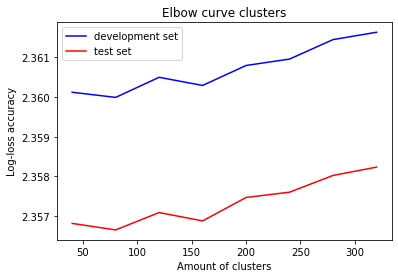

----------------------------------------------------------
this is the C-parameter: 0.001
this is the best score: 2.3599895334428345
----------------------------------------------------------
40
training took 22.215953588485718 seconds
this is the codebooksize: 40
this is the best score: 2.2682369099721287
80
training took 4.901401519775391 seconds
this is the codebooksize: 80
this is the best score: 2.2643854813807947
120
training took 25.495334148406982 seconds
this is the codebooksize: 120
this is the best score: 2.2615750326672157
160
training took 31.507758617401123 seconds
this is the codebooksize: 160
this is the best score: 2.260778272603288
200
training took 42.95692324638367 seconds
this is the codebooksize: 200
this is the best score: 2.2591828376329843
240
training took 39.717299699783325 seconds
this is the codebooksize: 240
this is the best score: 2.25880864985092
280
training took 60.794466495513916 seconds
this is the codebooksize: 280
this is the best score: 2.25873256

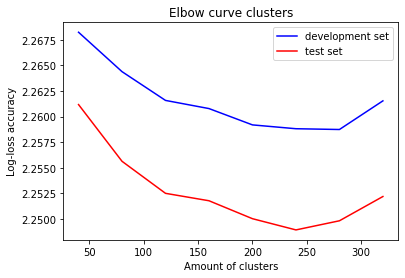

----------------------------------------------------------
this is the C-parameter: 0.01
this is the best score: 2.2587325698896734
----------------------------------------------------------


In [79]:
find_optimal_C_parameter2([0.001,0.01]) 

200
training took 285.9620711803436 seconds
this is the codebooksize: 200
this is the best score: 1.2889956149701183
400
training took 429.8625190258026 seconds
this is the codebooksize: 400
this is the best score: 1.2190344004074443
600
training took 475.36665630340576 seconds
this is the codebooksize: 600
this is the best score: 1.2031019101269385
800
training took 583.3562831878662 seconds
this is the codebooksize: 800
this is the best score: 1.1894963865673873
1000
training took 763.2274000644684 seconds
this is the codebooksize: 1000
this is the best score: 1.1525060574719423
1200
training took 831.9789035320282 seconds
this is the codebooksize: 1200
this is the best score: 1.1358815398802016
1400
training took 844.4544668197632 seconds
1600
training took 1020.4686884880066 seconds
1800
training took 1119.5086767673492 seconds
this is the codebooksize: 1800
this is the best score: 1.1279870179747862
2000
training took 1181.2621188163757 seconds
2200
training took 1356.204483270645

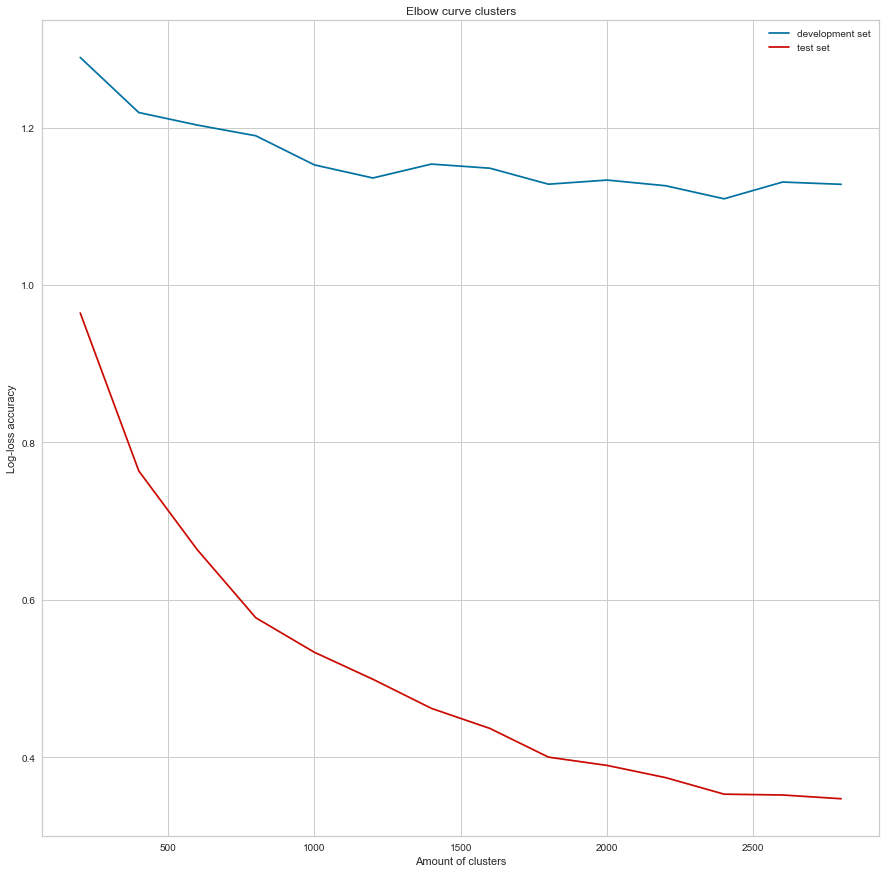

----------------------------------------------------------
this is the C-parameter: 15
this is the best score: 1.10944870626112
----------------------------------------------------------


In [83]:
find_optimal_C_parameter([15]) 

2
training took 19.638460397720337 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
4
training took 9.858799457550049 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
6
training took 7.3755879402160645 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
8
training took 6.0077409744262695 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
10
training took 7.32860255241394 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
12
training took 5.206884384155273 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', '

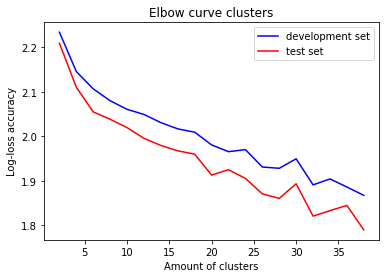

In [65]:
plot_cluster_graph(2, 40 , 2)

40
training took 15.959920883178711 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
80
training took 4.996805191040039 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
120
training took 21.379392862319946 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
160
training took 36.0524685382843 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
200
training took 39.728636264801025 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]
240
training took 46.72575759887695 seconds
['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chi

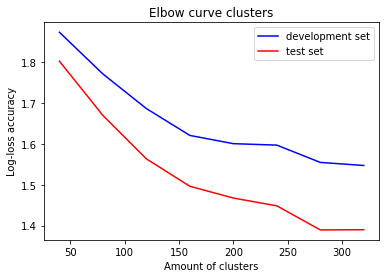

In [66]:
plot_cluster_graph(40, 360 , 40)

400
training took 99.26689791679382 seconds
this is the codebooksize: 400
this is the best score: 1.520031997771829
600
training took 99.2842538356781 seconds
this is the codebooksize: 600
this is the best score: 1.4804158484590166
800
training took 150.3817241191864 seconds
this is the codebooksize: 800
this is the best score: 1.4644478142830162
1000
training took 215.35029554367065 seconds
this is the codebooksize: 1000
this is the best score: 1.4589723283072564
1200
training took 281.95397877693176 seconds
1400
training took 359.70149207115173 seconds
this is the codebooksize: 1400
this is the best score: 1.4584677623324342
1600
training took 423.5145320892334 seconds
this is the codebooksize: 1600
this is the best score: 1.4470037466054666
1800
training took 558.9941096305847 seconds
this is the codebooksize: 1800
this is the best score: 1.4451386042992191
2000
training took 668.6910889148712 seconds
2200
training took 808.3007283210754 seconds
2400
training took 895.6063785552979 

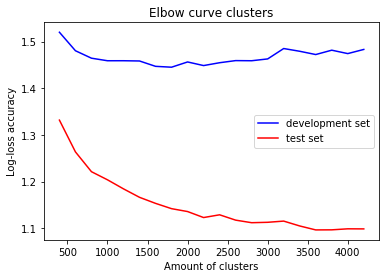

In [73]:
plot_cluster_graph(400, 4400 , 200)   

## Using the preffered classifier for the cross val curve 

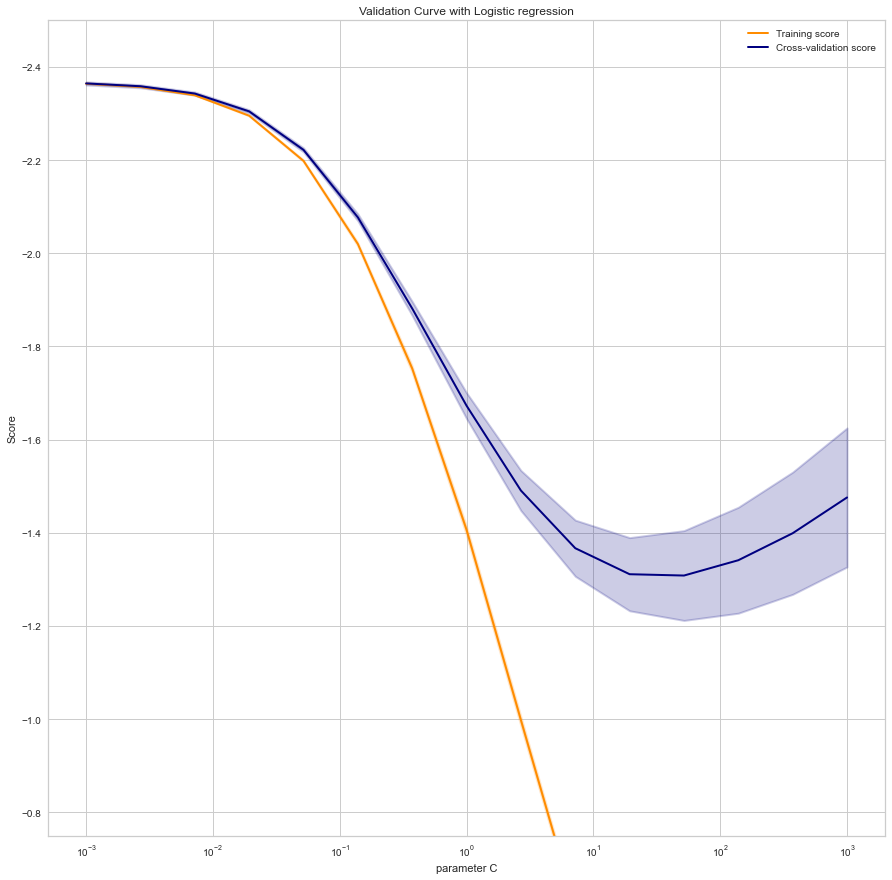

In [33]:
from imblearn.over_sampling import SMOTE
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)



param_range = np.logspace(-3, 3, 15)
train_scores, test_scores = validation_curve(
LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()



score after standard scaling


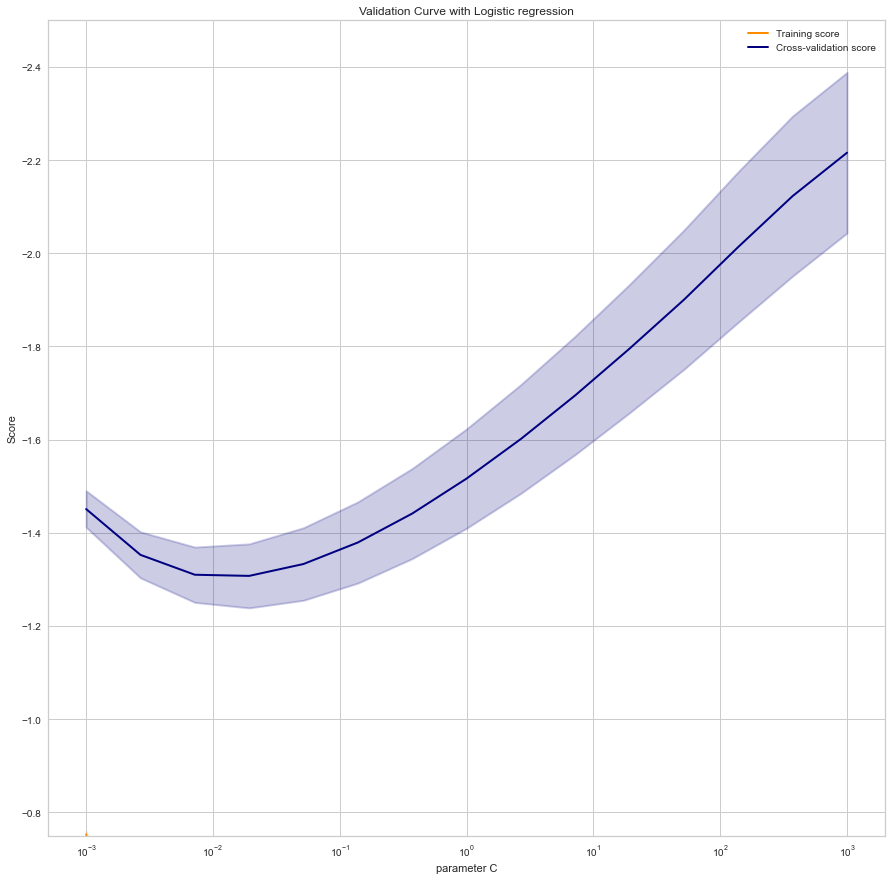

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
print('score after standard scaling')
X = StandardScaler().fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)


param_range = np.logspace(-3, 3, 15)
train_scores, test_scores = validation_curve(
LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


score after min-max scaling


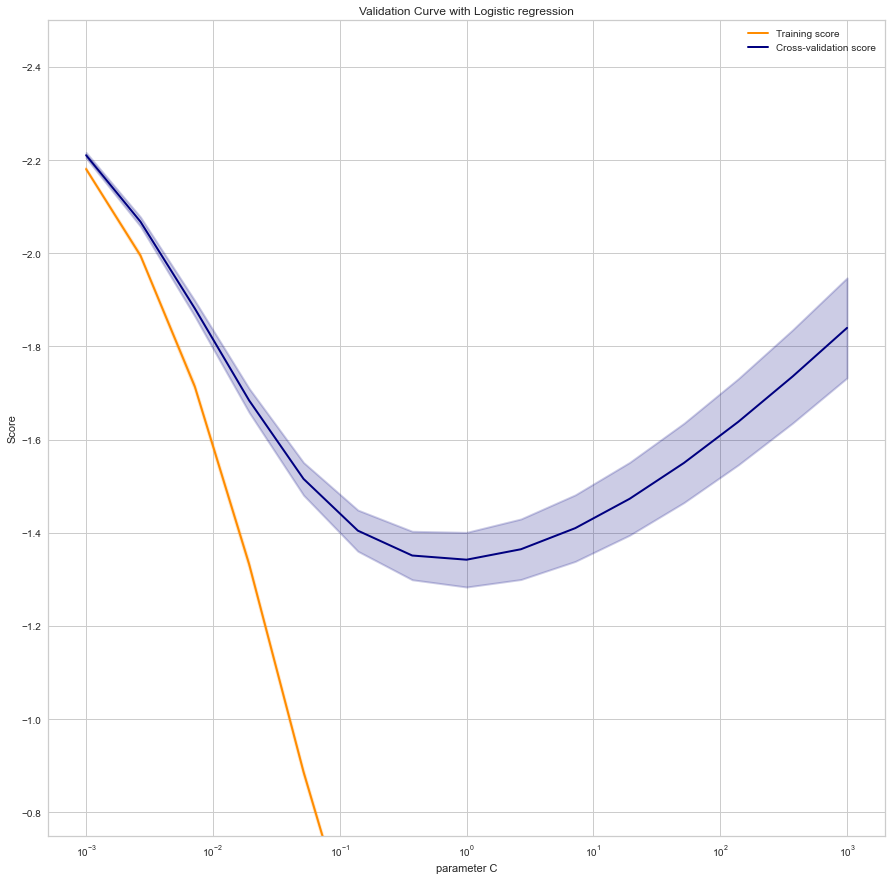

In [42]:
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)


print('score after min-max scaling')
X = MinMaxScaler().fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)
param_range = np.logspace(-3, 3, 15)
train_scores, test_scores = validation_curve(
LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

score after max abs scaling


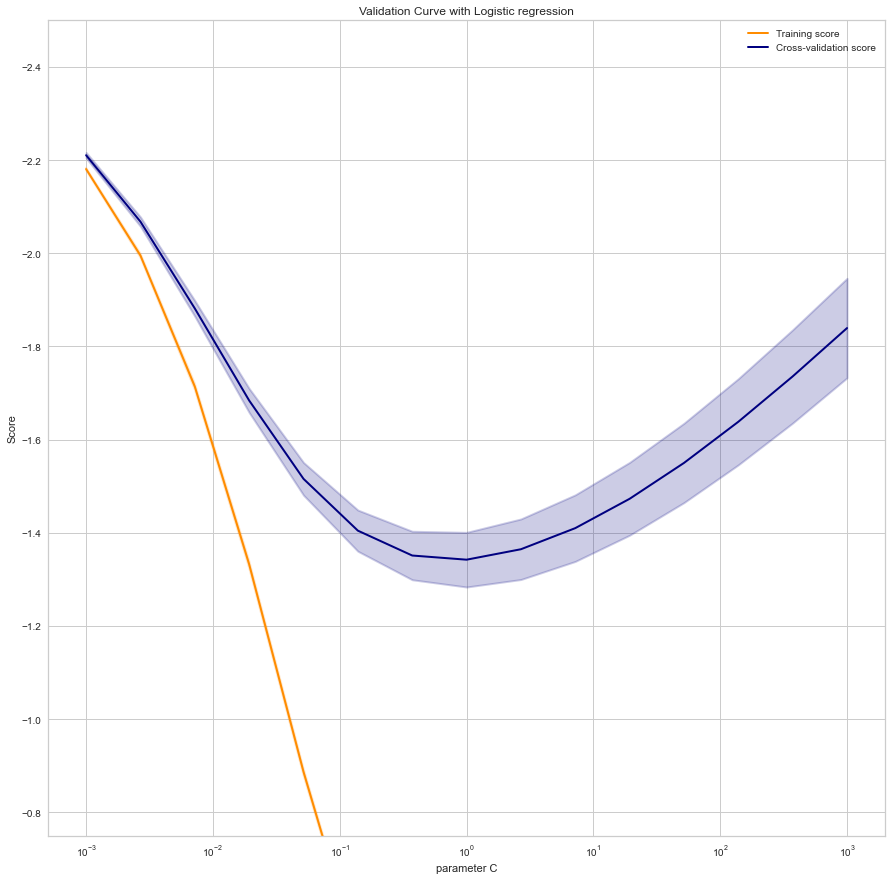

In [41]:
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)


print('score after max abs scaling')
X = MaxAbsScaler().fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)
param_range = np.logspace(-3, 3, 15)
train_scores, test_scores = validation_curve(
LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Score after robust scaling, and quantile:1


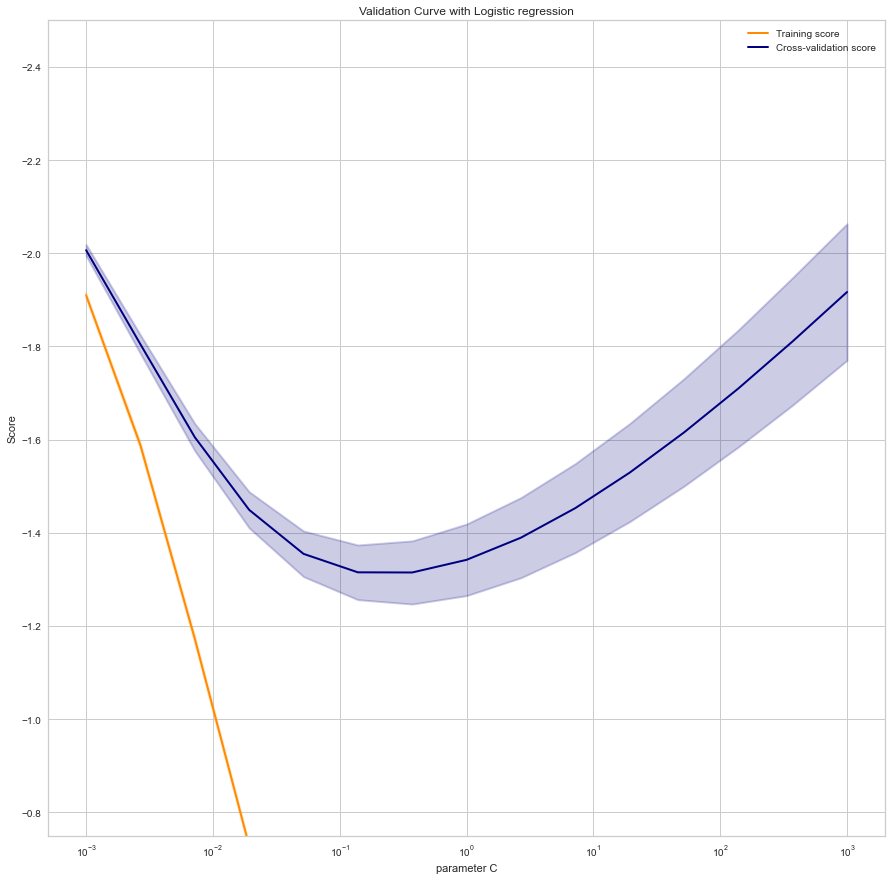

Score after robust scaling, and quantile:2


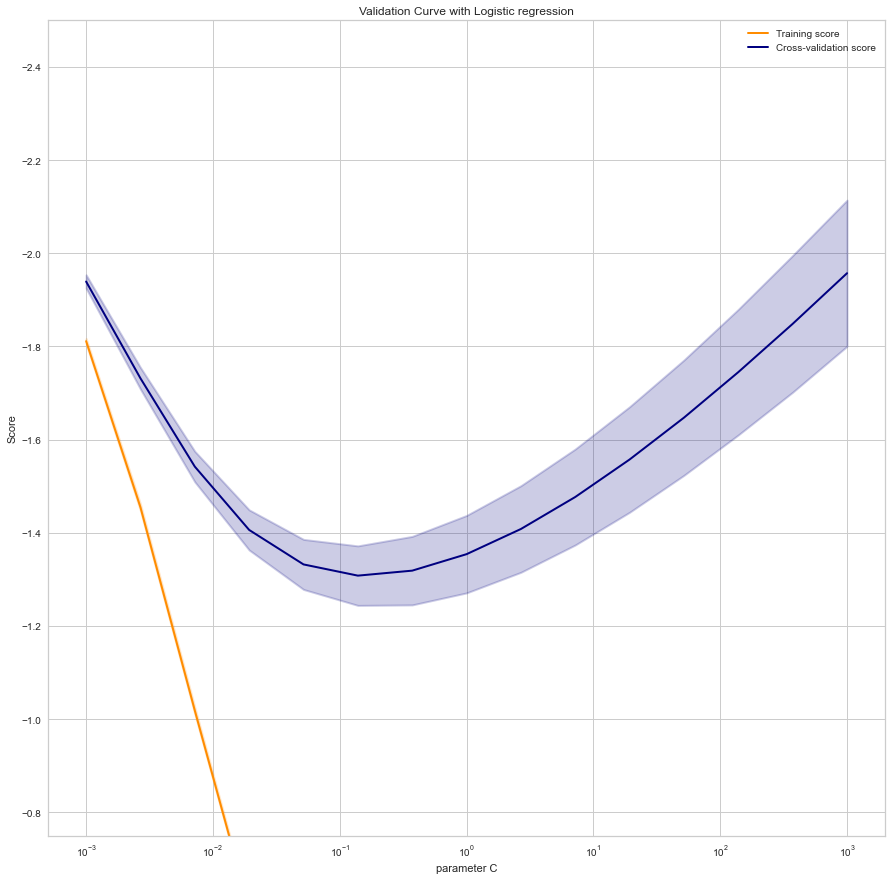

Score after robust scaling, and quantile:5


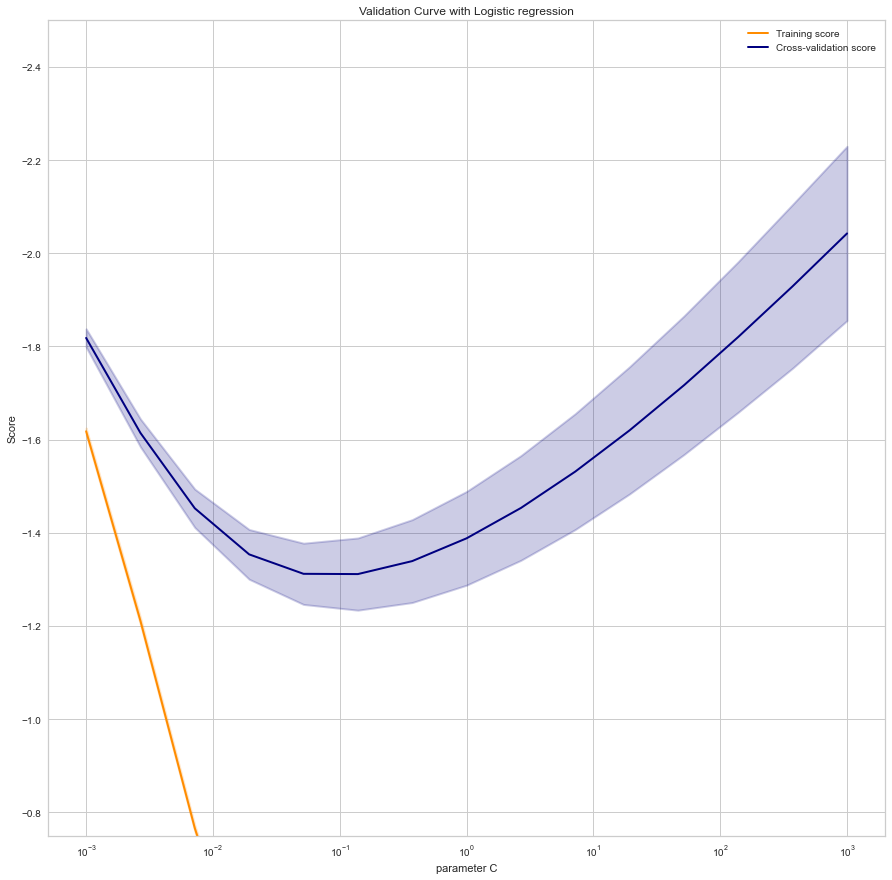

Score after robust scaling, and quantile:10


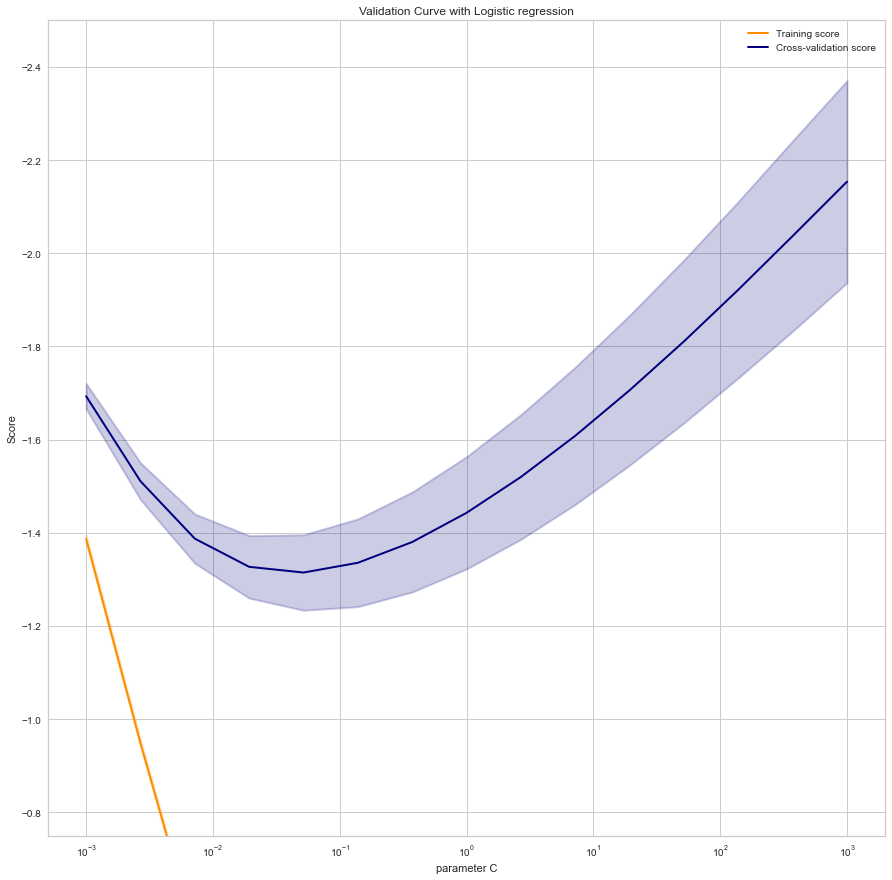

Score after robust scaling, and quantile:15


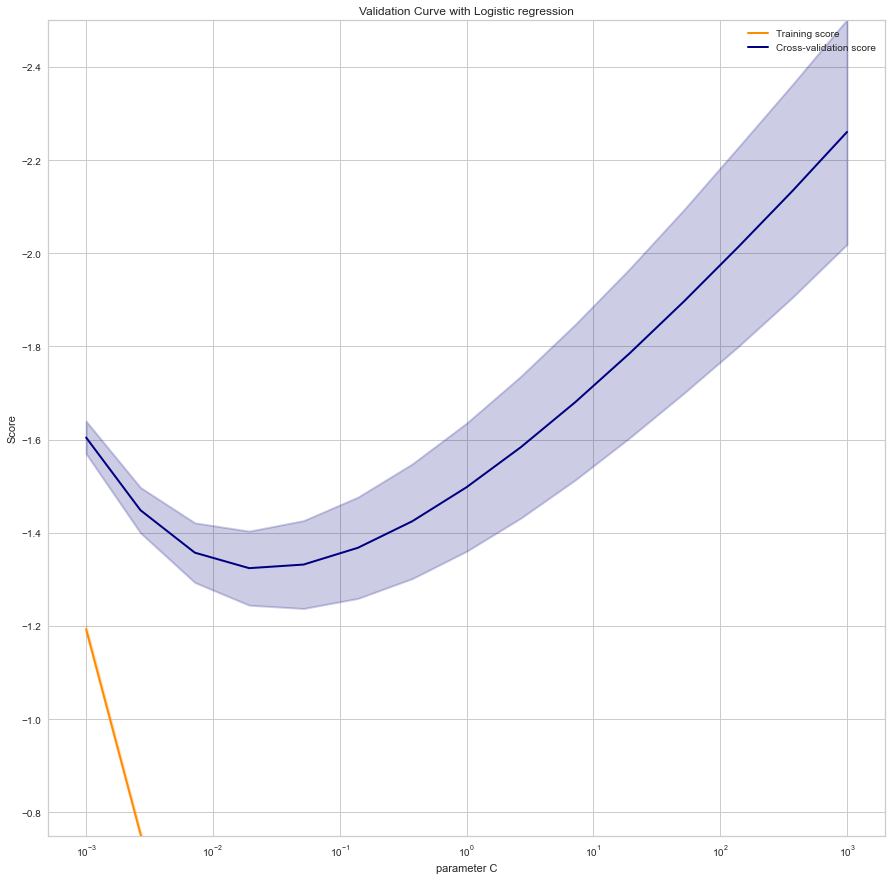

Score after robust scaling, and quantile:20


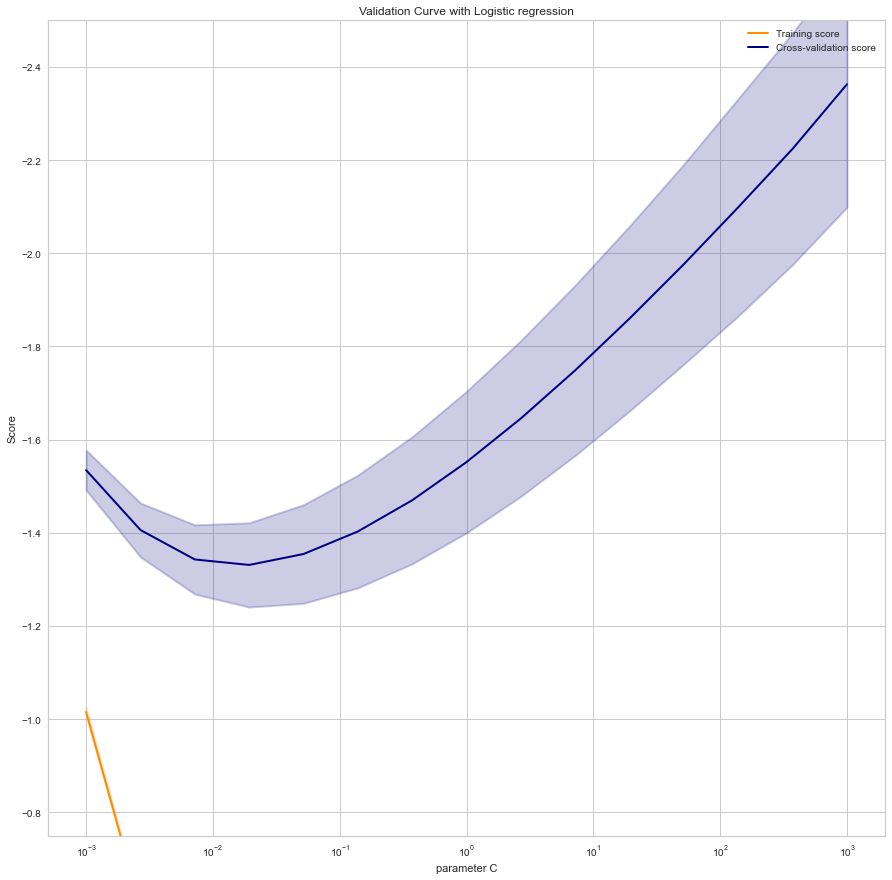

Score after robust scaling, and quantile:25


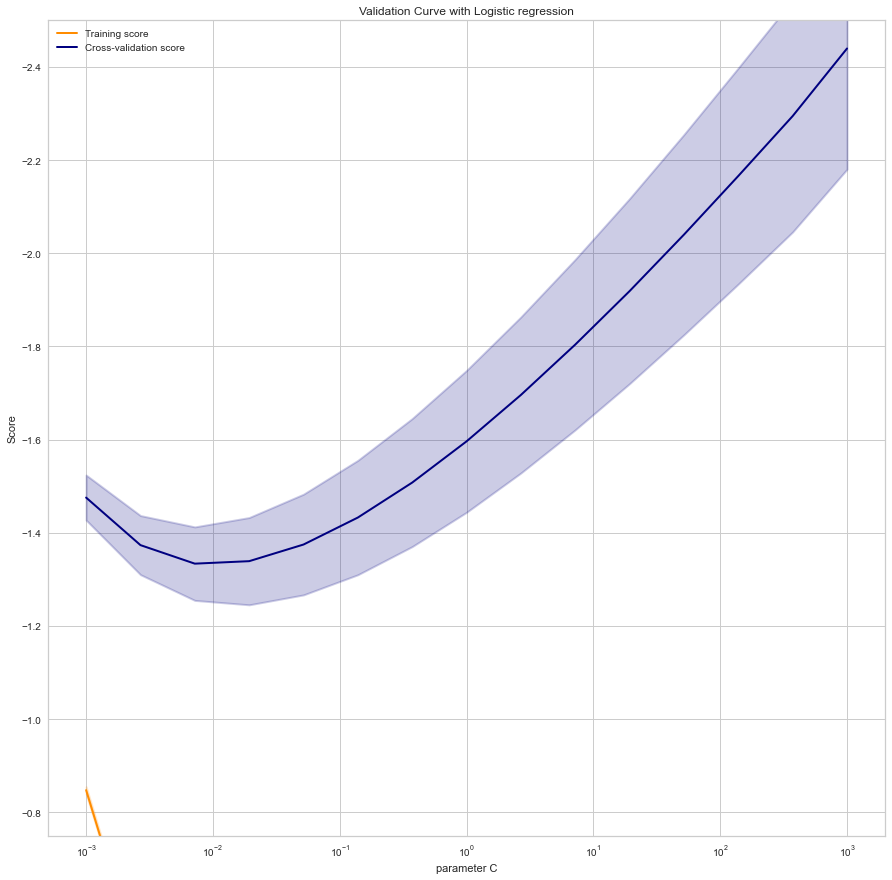

In [40]:
robust_range = [1 , 2 , 5 , 10 , 15 , 20 , 25]
for quantile in robust_range:
    X = train_data
    Y = train_labels
    Train_data_copy = train_data
    train_labels_copy = train_labels
    Train_data_copy = np.array(Train_data_copy)
    train_labels_copy = np.array(train_labels_copy)
    print('Score after robust scaling, and quantile:' + str(quantile))
    X = RobustScaler(quantile_range=(quantile,100 - quantile)).fit_transform(X)
    X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
    X_DEV_arr = np.array(X_DEV)
    Y_DEV_arr = np.array(Y_DEV)
    X_arr = np.array(X)
    Y_arr = np.array(Y)
    param_range = np.logspace(-3, 3, 15)
    train_scores, test_scores = validation_curve(
    LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
        scoring=LogLoss, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.title("Validation Curve with Logistic regression")
    plt.xlabel("parameter C")
    plt.ylabel("Score")
    plt.ylim(-0.75, -2.5)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

Score after power transformation (Yeo-Johnson)


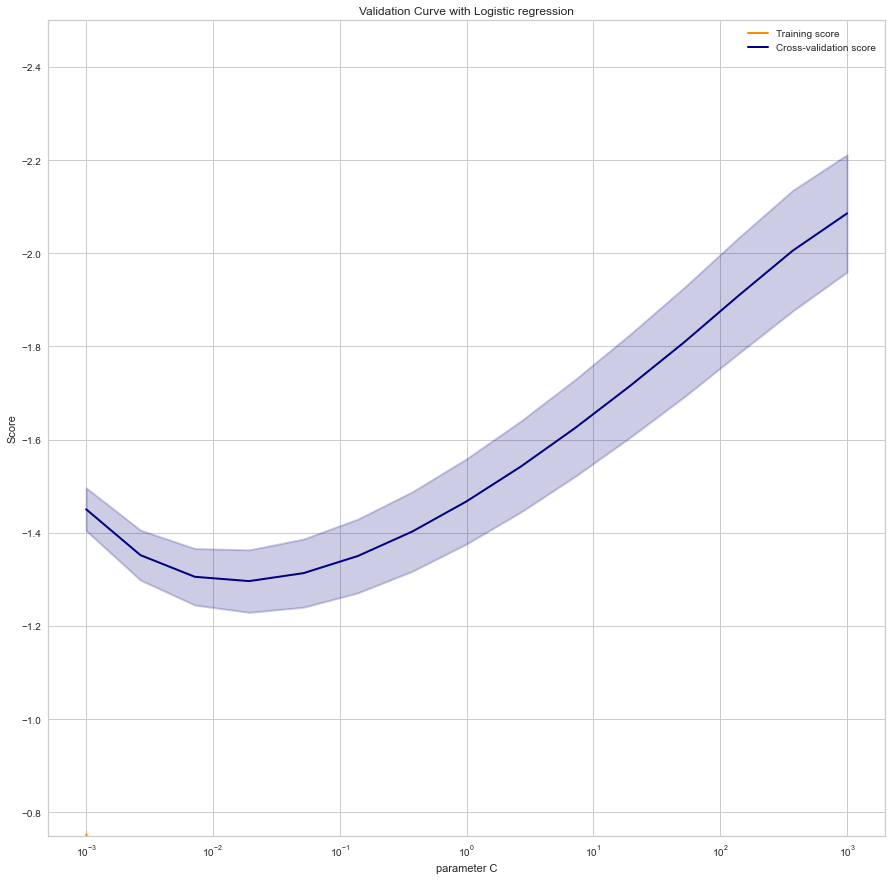

In [36]:
    
    
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)

    
print('Score after power transformation (Yeo-Johnson)')
X = PowerTransformer(method='yeo-johnson').fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)

param_range = np.logspace(-3, 3, 15)
train_scores, test_scores = validation_curve(
LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Score after quantile transformation (uniform pdf)


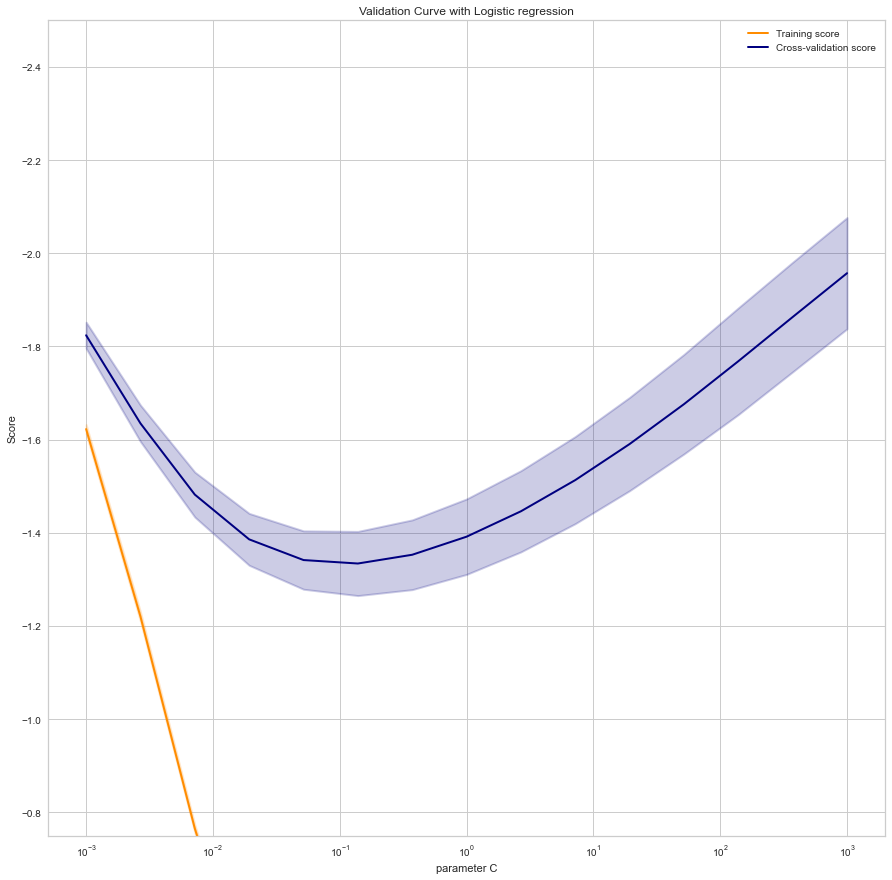

In [37]:
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
print('Score after quantile transformation (uniform pdf)')
X = QuantileTransformer(output_distribution='uniform').fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)

param_range = np.logspace(-3, 3, 15)
train_scores, test_scores = validation_curve(
LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Score after quantile transformation (gaussian pdf)


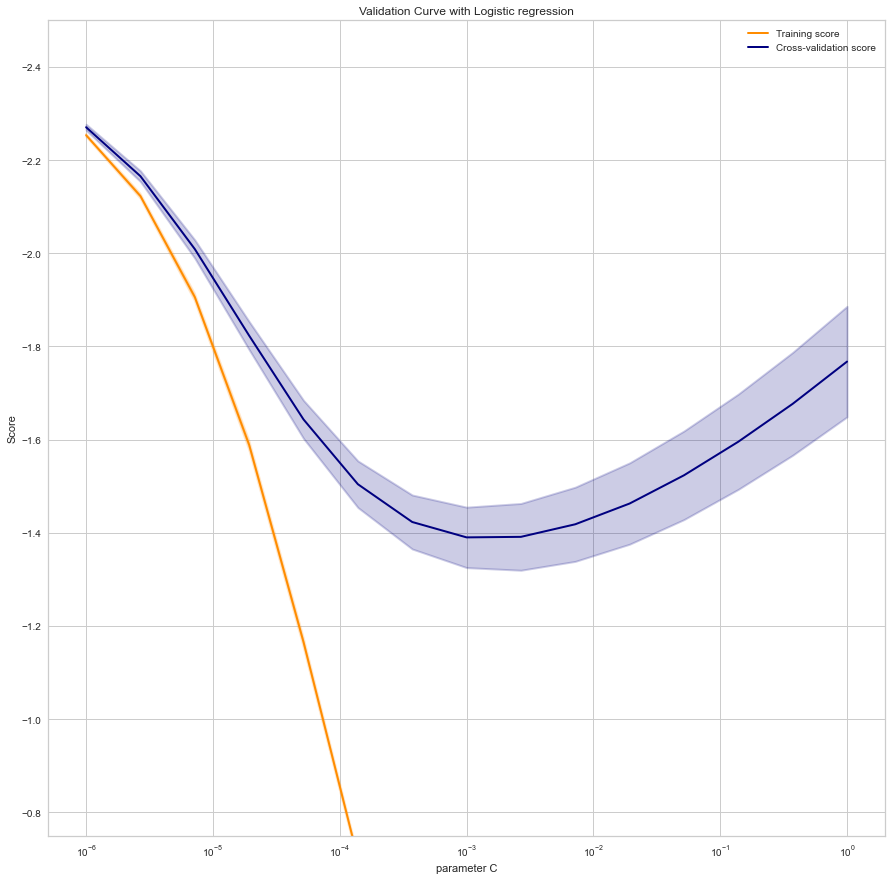

In [43]:
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)


print('Score after quantile transformation (gaussian pdf)')
X = QuantileTransformer(output_distribution='normal').fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)

param_range = np.logspace(-6, 0, 15)
train_scores, test_scores = validation_curve(
LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Score after sample-wise L2 normalizing


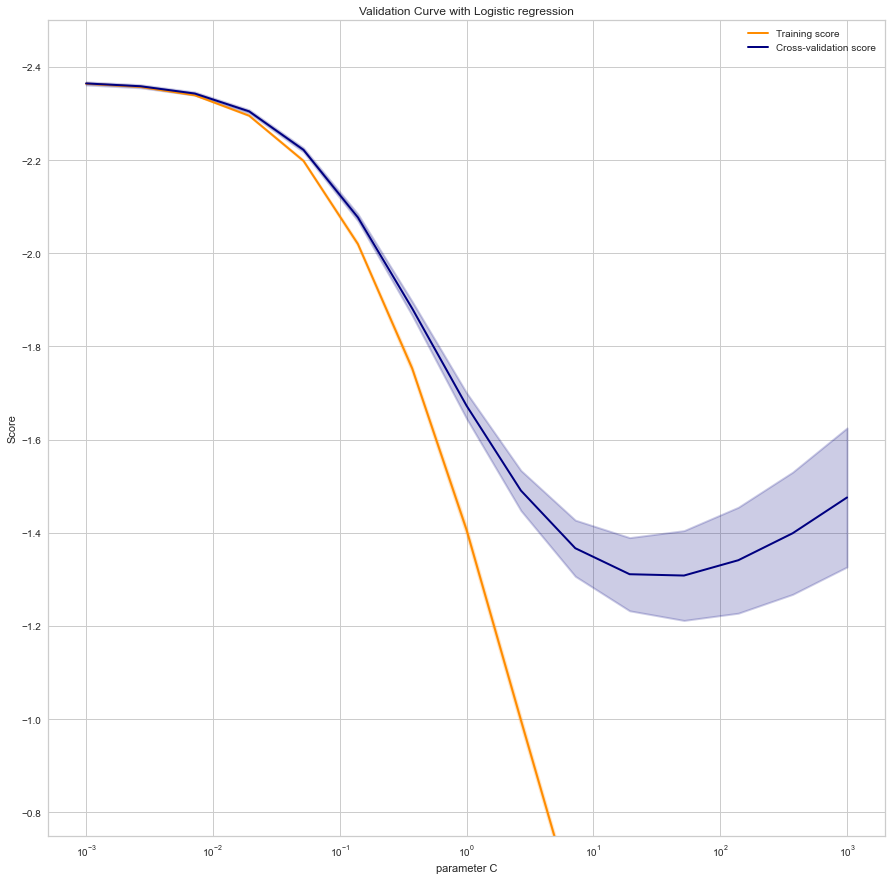

In [39]:
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)



print('Score after sample-wise L2 normalizing')
X = Normalizer().fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)

param_range = np.logspace(-3, 3, 15)
train_scores, test_scores = validation_curve(
LogisticRegression(max_iter= 2000), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


fig, ax = plt.subplots(figsize=(15, 15))

plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [100]:
from sklearn.pipeline import Pipeline


# encode all test images 
test_data = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)

In [63]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd




pred_test_full = 0
X = train_data
Y = train_labels


X = pd.DataFrame(X) 
Y = pd.DataFrame(Y)


param_grid = {
    'log__C': np.logspace(-4, 4, 15),
}
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
i = 0
param = {'C':np.logspace(-3, -1, 15)}
for train_index,test_index in kf.split(X,Y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = Y.loc[train_index],Y.loc[test_index]
    model = Pipeline([('yeo', PowerTransformer(method='yeo-johnson')), ("log", LogisticRegression(C = 20 , max_iter= 2000))])
    model = GridSearchCV(model,param_grid, cv=3, scoring=LogLoss,iid=True)
    model.fit(xtr, ytr.values.ravel())
    print (model.best_params_)
    pred=model.predict_proba(xvl)
    print('logloss_score',log_loss(yvl,pred))
    pred_test = model.predict_proba(test_data)
    pred_test_full +=pred_test
    i+=1
    
    


0 of kfold 5


C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'log__C': 0.005179474679231213}
logloss_score 1.0782158970486566

1 of kfold 5


C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'log__C': 0.005179474679231213}
logloss_score 1.0625657676517424

2 of kfold 5


C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'log__C': 0.005179474679231213}
logloss_score 1.0908365772929423

3 of kfold 5


C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'log__C': 0.005179474679231213}
logloss_score 1.0953628112585467

4 of kfold 5


C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'log__C': 0.005179474679231213}
logloss_score 1.1067832127264312


In [123]:
from imblearn.over_sampling import SMOTE 
  
    
    
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)





X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.5,random_state=2) #0.8 split gave us optimal results!


count_class_golden_retriever = 250
count_class_fox = 250
sm = SMOTE(sampling_strategy = {2: count_class_fox , 4: count_class_golden_retriever},random_state=2)
X_DEV, Y_DEV = sm.fit_sample(X_DEV,Y_DEV)

X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)
test_data = np.array(test_data)





logreg_best = LogisticRegression(C= 20  , max_iter= 2000 )



logreg_best.fit(X_DEV,Y_DEV)
logistic_regression_predictions = logreg_best.predict_proba(test_data)

C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


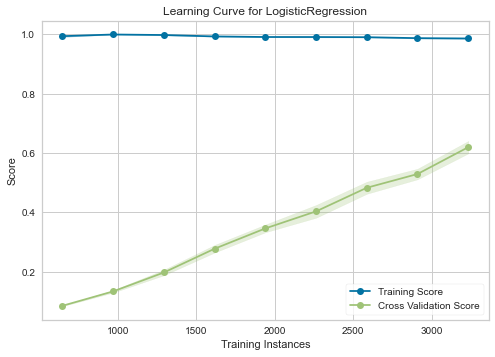

<AxesSubplot:title={'center':'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [129]:
from yellowbrick.model_selection import LearningCurve


# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.1, 1.0, 10)

# Instantiate the classification model and visualizer
model = LogisticRegression(C= 20  , max_iter= 2000 )
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(train_data, train_labels)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


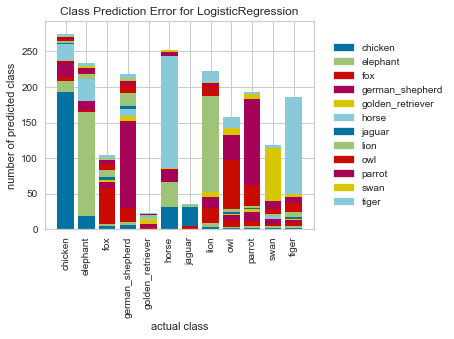

<AxesSubplot:title={'center':'Class Prediction Error for LogisticRegression'}, xlabel='actual class', ylabel='number of predicted class'>

In [124]:
from yellowbrick.classifier import ClassPredictionError


visualizer = ClassPredictionError(
    LogisticRegression(C= 20  , max_iter= 2000 ), classes=label_strings
)

# Fit the training data to the visualizer
visualizer.fit(X_DEV, Y_DEV)

# Evaluate the model on the test data
visualizer.score(X, Y)

# Draw visualization
visualizer.show()

current log_loss: 1.1522528104233078
Confusion matrix, without normalization
Normalized confusion matrix


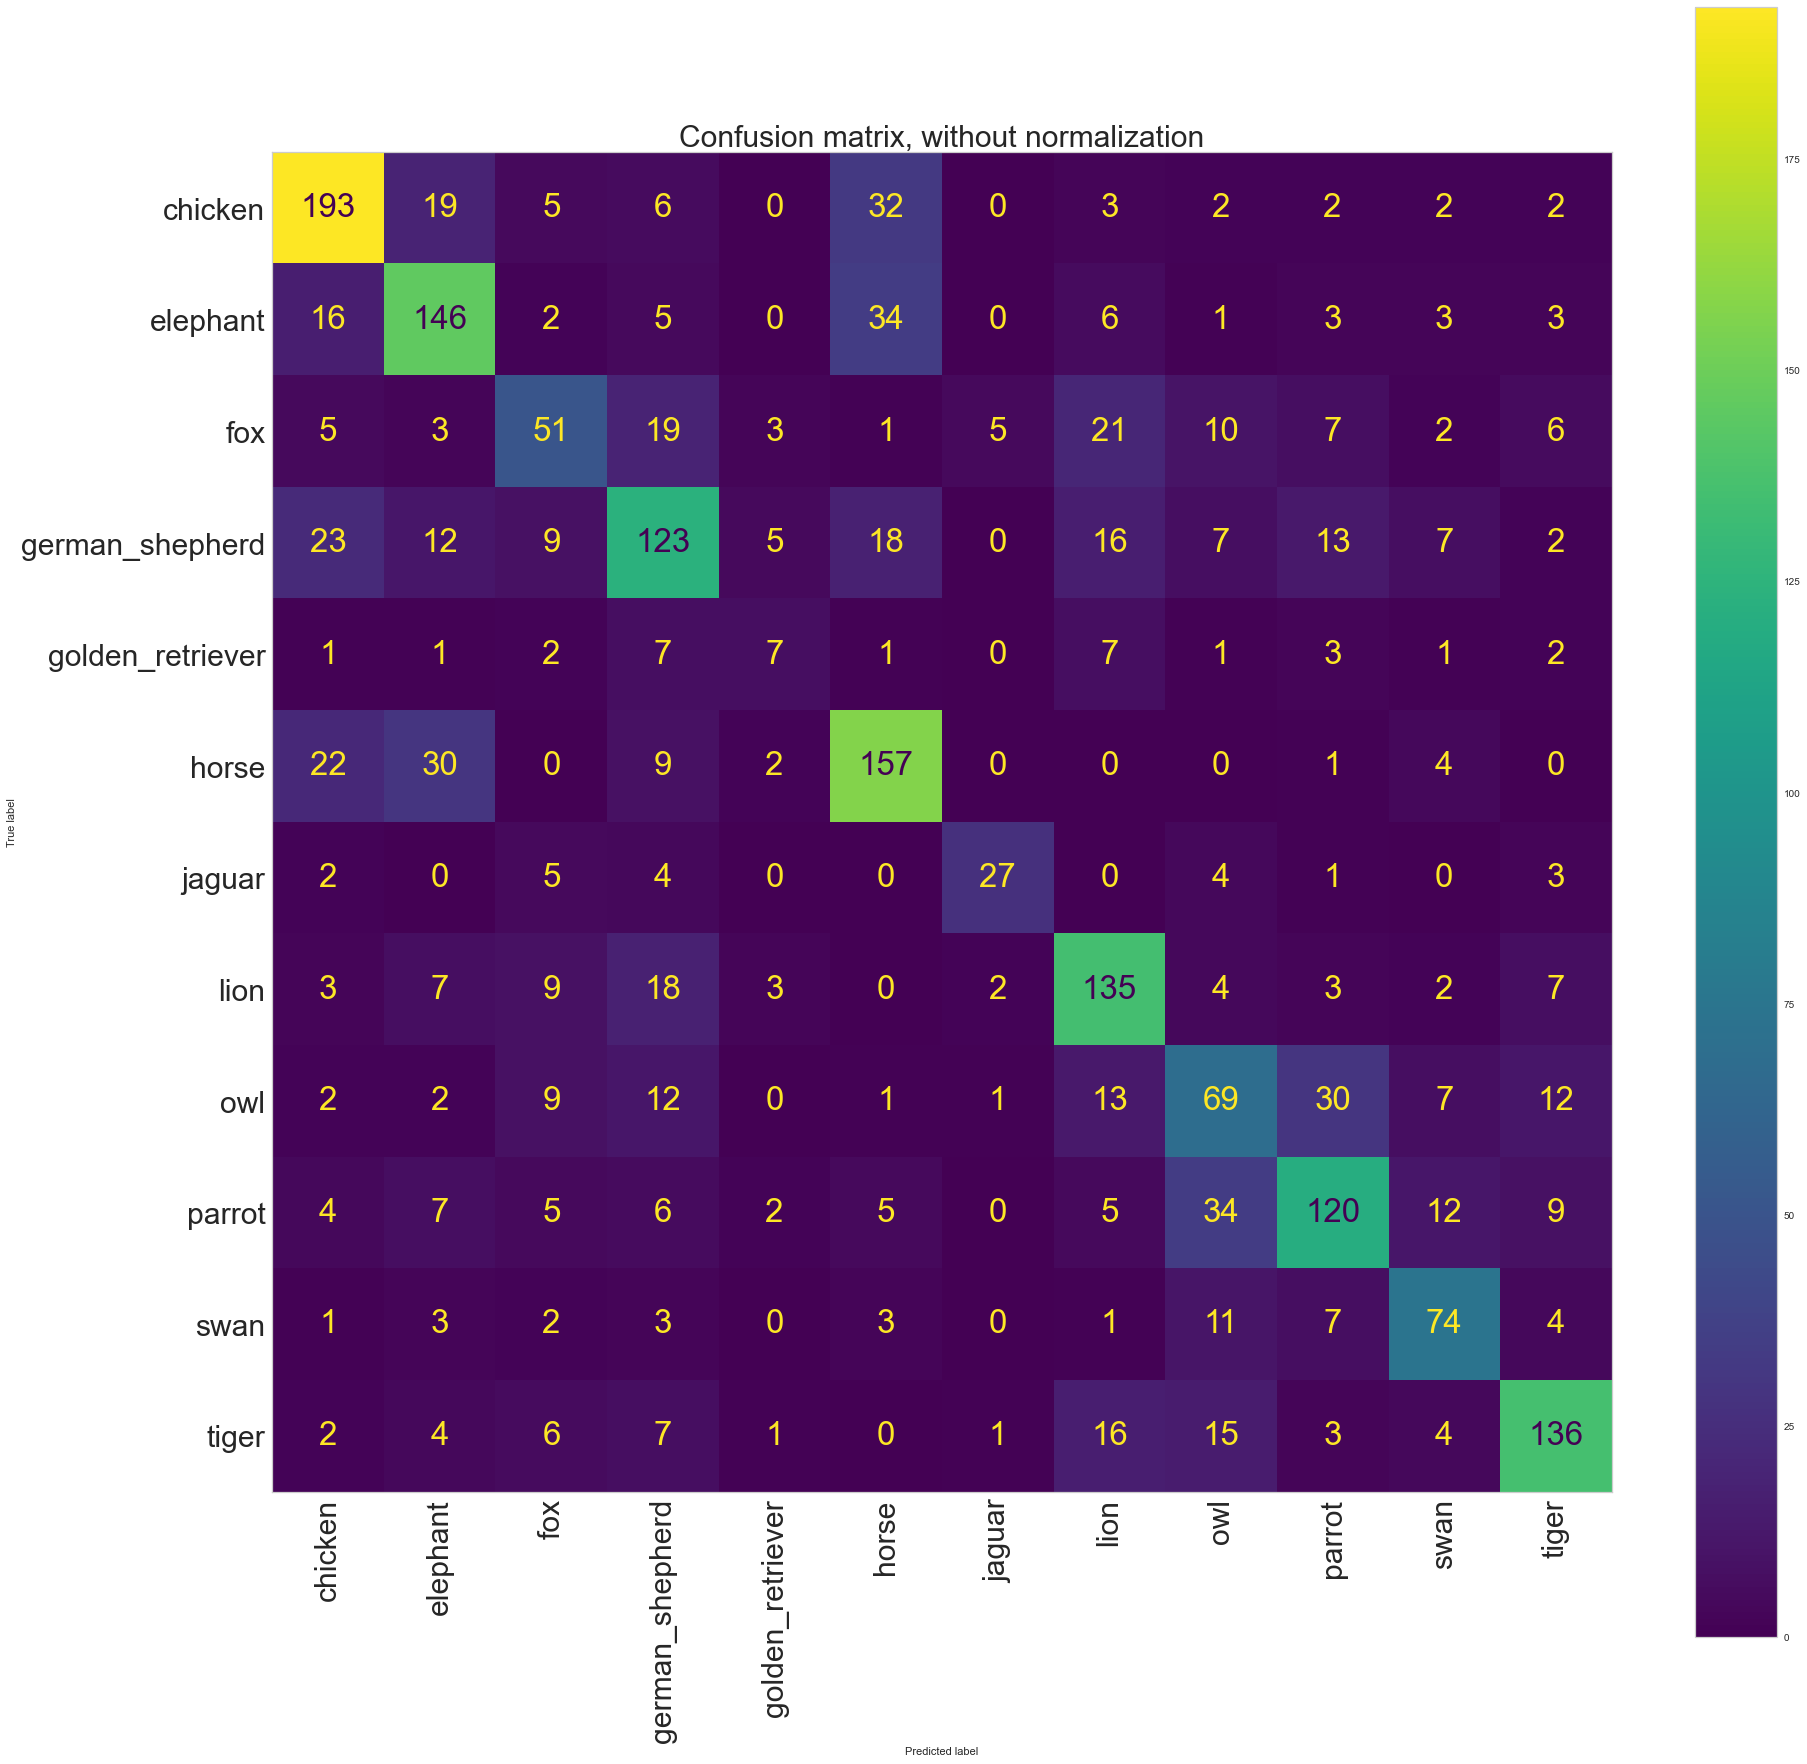

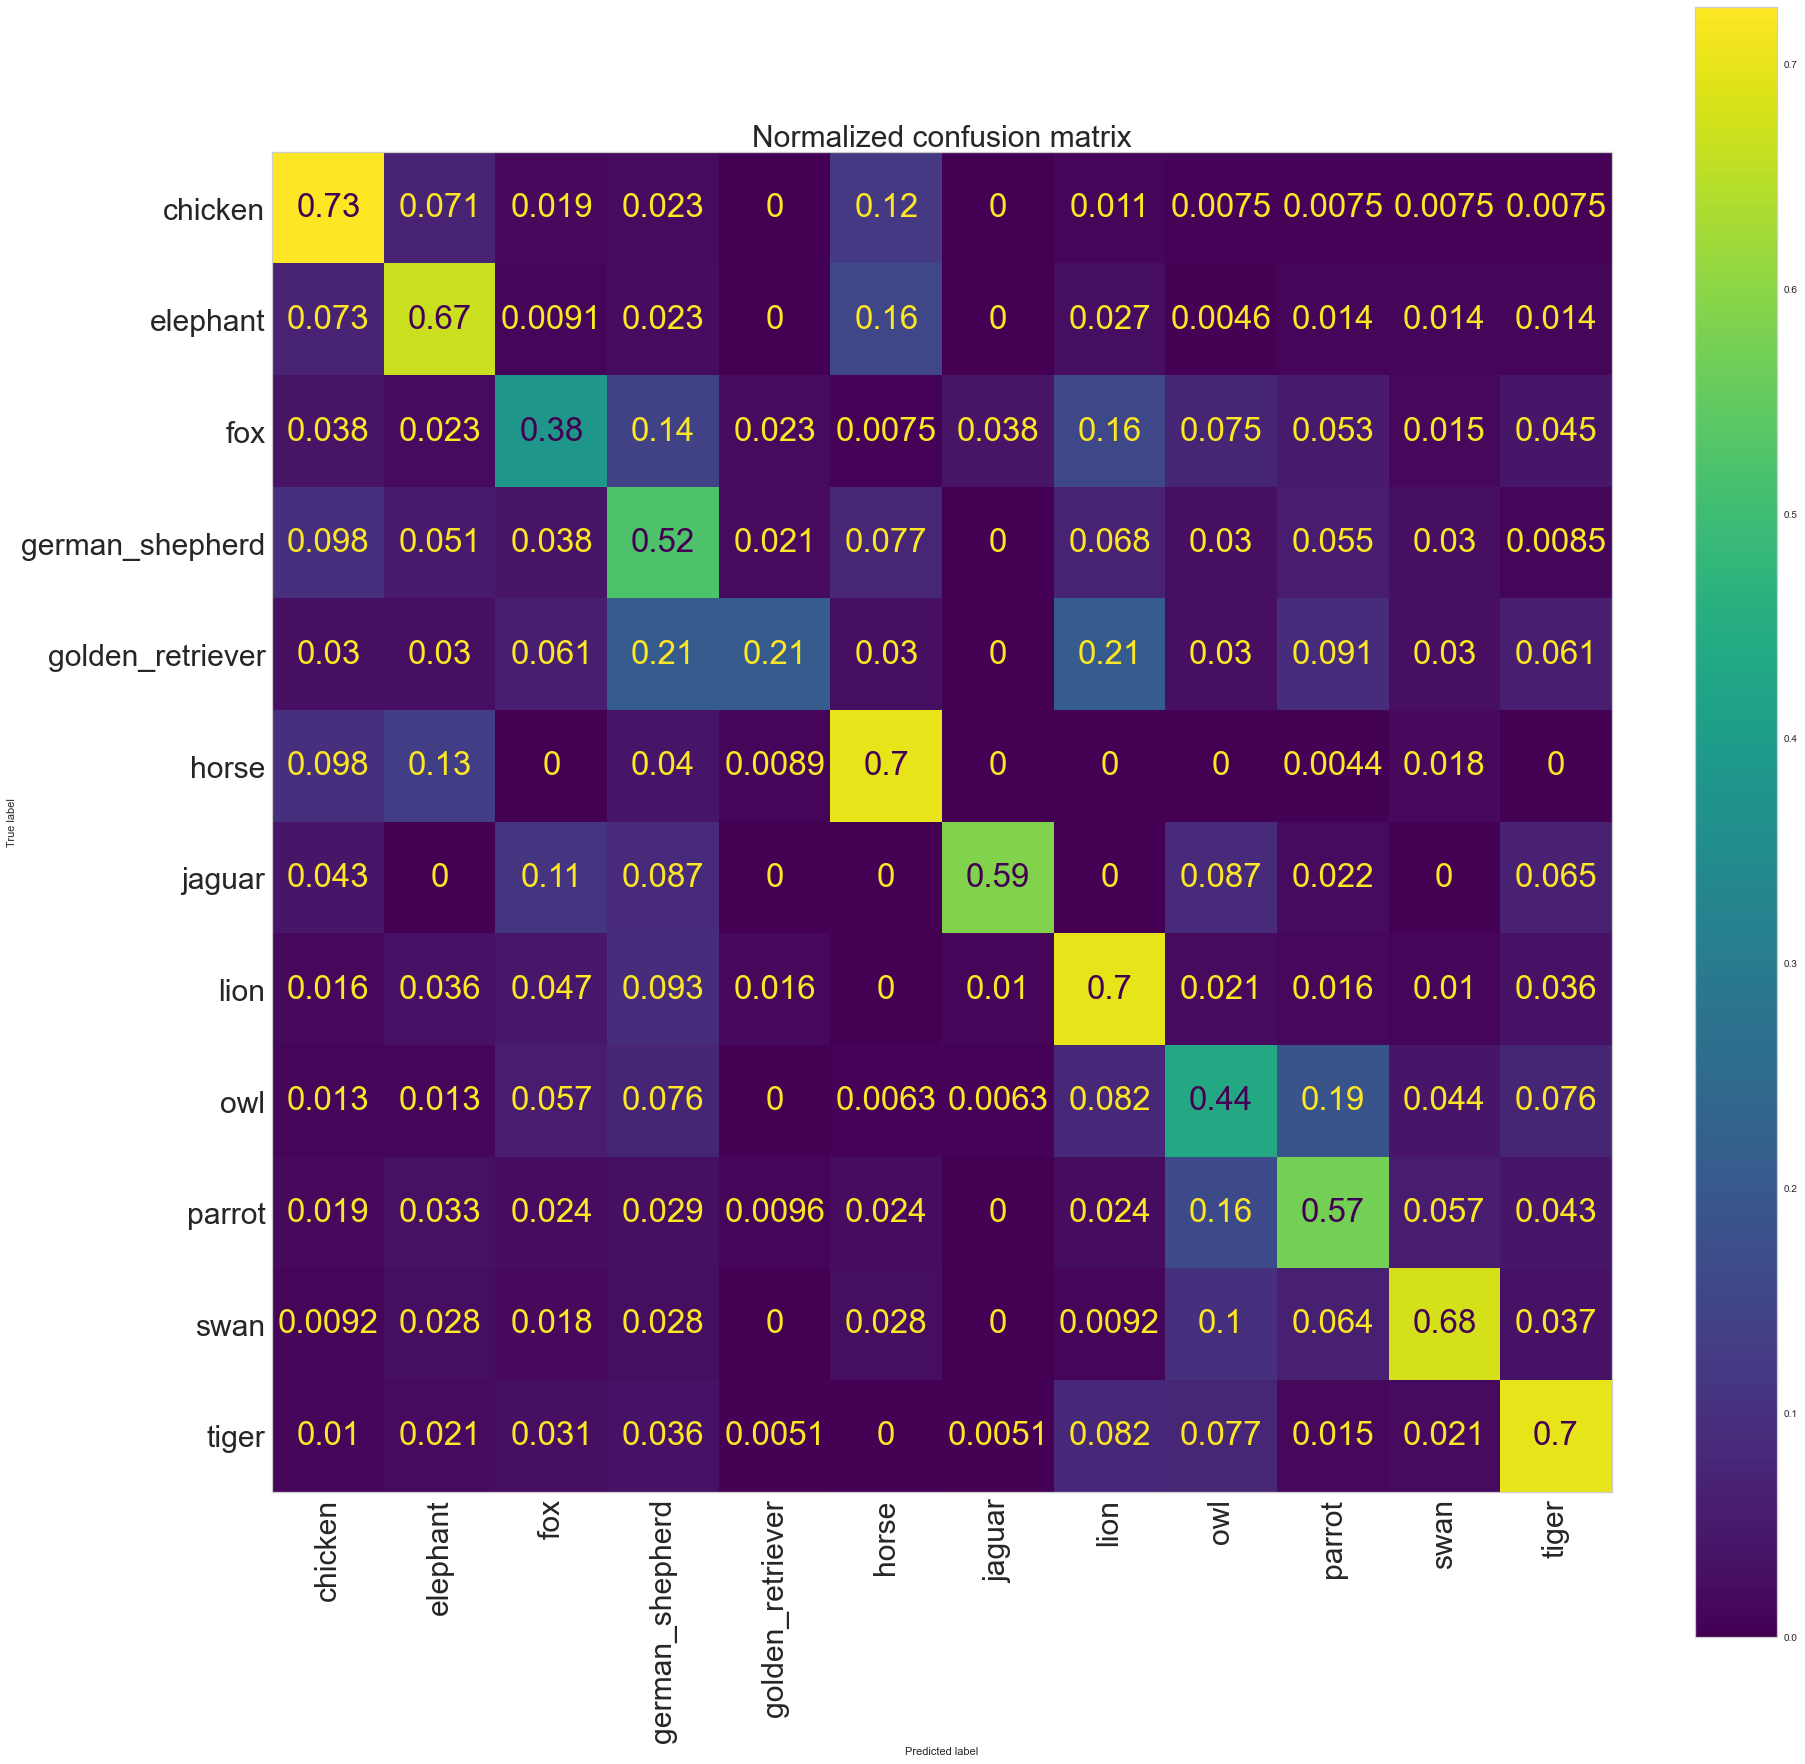

In [125]:

    



y_pred = logreg_best.predict(X)
logistic_regression_train = logreg_best.predict_proba(X)

acc_logreg = log_loss(Y, logistic_regression_train)
print("current log_loss: " + str(acc_logreg))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:

    fig, ax = plt.subplots(figsize=(30, 30))
    disp = plot_confusion_matrix(logreg_best, X, Y,
                                 display_labels=label_strings,
                                 xticks_rotation='vertical',
                                 normalize=normalize , ax = ax)
    ax.grid(False)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    disp.ax_.set_title(title , fontsize = 30)
    print(title)
    
    disp.confusion_matrix

plt.show()

## Using the preffered classifier for the learning curve

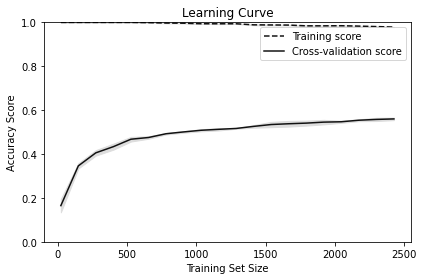

In [164]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(max_iter= 2000 , C=10), 
                                                        train_data, 
                                                        train_labels,
                                                        # Number of folds in cross-validation
                                                        cv=ShuffleSplit(n_splits=3, test_size=0.4, random_state=43),
                                                        # Evaluation metric
                                                        scoring="accuracy",
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 20))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Displaying the results of the pipeline

In [405]:
X = train_data
Y = train_labels

ch2 = SelectKBest(chi2, k =  1920)


sm = SMOTE(random_state=2)
X, Y = sm.fit_sample(X, Y)


C_range = np.logspace(2, 4, 7)
param_grid = dict(C=C_range)
split_strat = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
logreg_best = GridSearchCV(LogisticRegression(penalty = 'l2' , max_iter= 2000 ), param_grid = param_grid,  cv=split_strat)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=32) #0.8 split gave us optimal results!

logreg_best.fit(X_DEV,Y_DEV)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.3,
            train_size=None),
             estimator=LogisticRegression(max_iter=2000),
             param_grid={'C': array([ 1000.        ,  1467.79926762,  2154.43469003,  3162.27766017,
        4641.58883361,  6812.92069058, 10000.        ])})

In [406]:
print("tuned hpyerparameters :(best parameters) ",logreg_best.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0}


### Using bagging to improve the score

In [411]:
logreg_best = BaggingClassifier(base_estimator=LogisticRegression(C= 1000 , penalty = 'l2' , max_iter= 2000 ),
                        n_estimators=1, random_state=0)

In [412]:
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.5,random_state=32) #0.8 split gave us optimal results!
logreg_best.fit(X_DEV,Y_DEV)
logistic_regression_predictions = logreg_best.predict_proba(test_data)

y_pred = logreg_best.predict(X)
logistic_regression_train = logreg_best.predict_proba(X)
acc_logreg = log_loss(Y, logistic_regression_train)
print("current log_loss: " + str(acc_logreg))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(logreg_best, X, Y,
                                 display_labels=label_strings,
                                 xticks_rotation='vertical',
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

ValueError: Number of features of the model must match the input. Model n_features is 1920 and input n_features is 2000.

## Using a pipeline to improve score

C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass param_name=logistic__C, param_range=[1.00000000e-03 2.68269580e-03 7.19685673e-03 1.93069773e-02
 5.17947468e-02 1.38949549e-01 3.72759372e-01 1.00000000e+00
 2.68269580e+00 7.19685673e+00 1.93069773e+01 5.17947468e+01
 1.38949549e+02 3.72759372e+02 1.00000000e+03] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


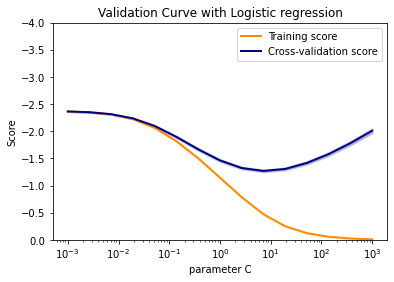

In [236]:
param_range = np.logspace(-3, 3, 15)
logistic = LogisticRegression(max_iter= 2000)
pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

params={'logistic__C':param_range}

train_scores, test_scores = validation_curve(
pipe, X_DEV,Y_DEV, 'logistic__C' ,param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(0.0, -4.0)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## Using a bagging classifier to improve performance

current log_loss: 1.1938798749381248
Confusion matrix, without normalization
[[71  7  0  1  0  8  0  1  3  0  0  0]
 [12 44  1  4  0 22  0  2  1  3  0  1]
 [ 3  1 20 13  0  1  0 12  2  6  0  2]
 [ 2  4  6 55  0  4  0  9  2  5  2  1]
 [ 1  0  1  6  2  1  0  2  0  0  1  0]
 [12 11  0  3  0 54  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  6  2  0  0  0  5]
 [ 0  0  7  5  0  0  0 50  4  4  0  1]
 [ 2  2  3  5  0  0  1  6 31 11  2  9]
 [ 0  5  2 11  0  2  0  3 12 52  4  0]
 [ 0  1  1  0  0  0  0  0  3 10 25  2]
 [ 1  1  1  9  0  0  0 10  8  6  1 55]]
Normalized confusion matrix
[[0.78021978 0.07692308 0.         0.01098901 0.         0.08791209
  0.         0.01098901 0.03296703 0.         0.         0.        ]
 [0.13333333 0.48888889 0.01111111 0.04444444 0.         0.24444444
  0.         0.02222222 0.01111111 0.03333333 0.         0.01111111]
 [0.05       0.01666667 0.33333333 0.21666667 0.         0.01666667
  0.         0.2        0.03333333 0.1        0.         0.03333333]
 [0.02222222 0.

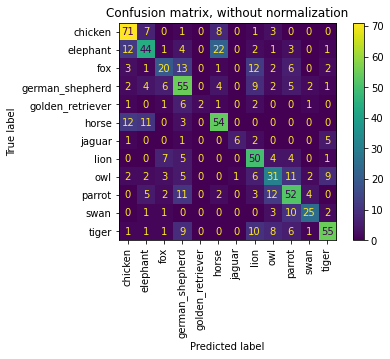

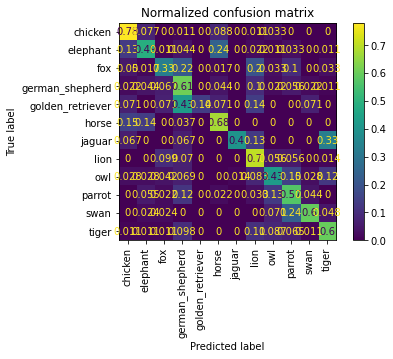

In [167]:
from sklearn.ensemble import BaggingClassifier
X = SelectKBest(chi2, k =  1920).fit_transform(X,Y)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.8,random_state=42) #0.8 split gave us optimal results!


logreg_best = LogisticRegression(C = 10 , penalty = 'l2' , max_iter= 2000 )
logreg_best = BaggingClassifier(base_estimator=logreg_best,
                        n_estimators=100, random_state=0)


logreg_best.fit(X_DEV,Y_DEV)
logistic_regression_predictions = logreg_best.predict_proba(test_data)

y_pred = logreg_best.predict(X)
logistic_regression_train = logreg_best.predict_proba(X)
acc_logreg = log_loss(Y, logistic_regression_train)
print("current log_loss: " + str(acc_logreg))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(logreg_best, X, Y,
                                 display_labels=label_strings,
                                 xticks_rotation='vertical',
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

## Finding the elbow for the clustering (using svm , rbf kernel)

In [13]:
def find_optimal_CGAMMA_parameter(lijst , lijst2):
    best_score = 999999
    for i in lijst:
        for j in lijst2:
            potential_score = plot_cluster_graph(1800, 2800 , 200 , i , j) 
            if potential_score < best_score:
                best_score = potential_score
                print("----------------------------------------------------------")
                print("this is the C-parameter: " + str(i))
                print("this is the gamma-parameter: " + str(j))
                print("this is the best score: " + str(best_score))
                print("----------------------------------------------------------")

In [14]:
def plot_cluster_graph(minimum, maximum , step , C_param , gamma_param):
    amount_of_zeroes = (maximum-minimum) // step
    DEV_errors = np.zeros(amount_of_zeroes)
    X_errors = np.zeros(amount_of_zeroes)
    codebook_sizes = np.zeros(amount_of_zeroes)
    idx = 0
    best_score = 99999999
    for i in range(minimum, maximum , step):
        codebook_size = i
        print(str(codebook_size))
        
        
        clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)
        
        train_data = []
        train_labels = []
        for image_features in train_features_from_pkl:
            bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
            train_data.append(bow_feature_vector)
            train_labels.append(image_features.label)
            
            
        test_data = []
        for image_features in test_features_from_pkl:
            bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
            test_data.append(bow_feature_vector)
        
        label_encoder = sklearn.preprocessing.LabelEncoder()
        label_encoder.fit(label_strings)
        train_labels = label_encoder.transform(train_labels)
        X, X_DEV , Y , Y_DEV = train_test_split(train_data,train_labels,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
        
        
        logreg_best = SVC(C=C_param,gamma=gamma_param,probability=True)
        logreg_best.fit(X,Y)
        logistic_regression_dev = logreg_best.predict_proba(X_DEV)
        acc_logreg_dev = log_loss(Y_DEV, logistic_regression_dev)
        logistic_regression_test = logreg_best.predict_proba(X)
        acc_logreg_test = log_loss(Y, logistic_regression_test)
        DEV_errors[idx]=acc_logreg_dev
        X_errors[idx]=acc_logreg_test
        if acc_logreg_dev < best_score:
            best_score = acc_logreg_dev
            print("this is the codebooksize: " + str(i))
            print("this is the best score: " + str(best_score))
        
        idx = idx + 1
        
        
    plt.figure()
    plt.plot(np.arange(minimum,maximum,step),DEV_errors,c='b',label='development set')
    plt.plot(np.arange(minimum,maximum,step),X_errors,c='r',label='test set')
    plt.xlabel("Amount of clusters")
    plt.ylabel("Log-loss accuracy")
    plt.title("Elbow curve clusters")
    plt.legend()
    plt.show()
    return best_score

1800
training took 930.5912654399872 seconds
this is the codebooksize: 1800
this is the best score: 1.202840030404307
2000
training took 898.5816559791565 seconds
this is the codebooksize: 2000
this is the best score: 1.1925206558142678
2200
training took 1018.4372899532318 seconds
this is the codebooksize: 2200
this is the best score: 1.1905700059563005
2400
training took 1068.960131406784 seconds
this is the codebooksize: 2400
this is the best score: 1.1865180020074868
2600
training took 1173.5316092967987 seconds
this is the codebooksize: 2600
this is the best score: 1.1752575412375257


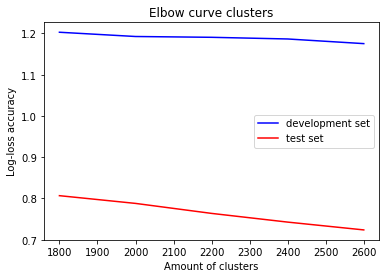

----------------------------------------------------------
this is the C-parameter: 50
this is the gamma-parameter: 0.01
this is the best score: 1.1752575412375257
----------------------------------------------------------
1800
training took 878.9680342674255 seconds
this is the codebooksize: 1800
this is the best score: 1.4985810454799964
2000
training took 910.6543381214142 seconds
this is the codebooksize: 2000
this is the best score: 1.4806506257905154
2200
training took 861.4464294910431 seconds
this is the codebooksize: 2200
this is the best score: 1.4774167985048883
2400
training took 948.6976587772369 seconds
this is the codebooksize: 2400
this is the best score: 1.4770577804816836
2600
training took 1186.5237746238708 seconds
this is the codebooksize: 2600
this is the best score: 1.4759701607059947


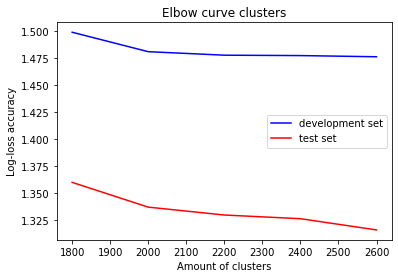

1800
training took 787.6002733707428 seconds
this is the codebooksize: 1800
this is the best score: 1.7318132326407567
2000
training took 856.0586366653442 seconds
this is the codebooksize: 2000
this is the best score: 1.722864673565179
2200
training took 983.9906806945801 seconds
this is the codebooksize: 2200
this is the best score: 1.6863631595423776
2400
training took 1091.2952551841736 seconds
2600
training took 1303.1828181743622 seconds


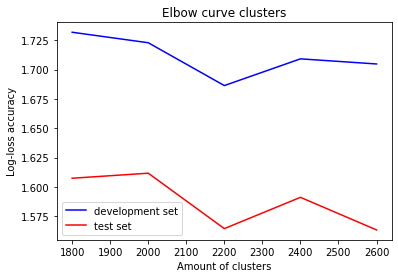

1800
training took 823.3714714050293 seconds
this is the codebooksize: 1800
this is the best score: 1.6812485280523224
2000
training took 866.9410033226013 seconds
2200
training took 906.7087762355804 seconds
2400
training took 1053.1438806056976 seconds
2600
training took 1252.0493121147156 seconds


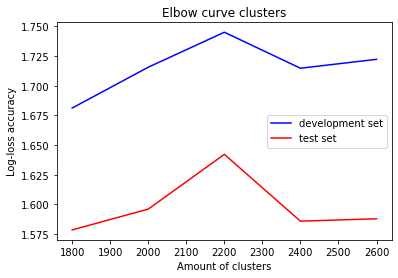

1800
training took 788.4308385848999 seconds
this is the codebooksize: 1800
this is the best score: 1.147339799867753
2000
training took 1044.5378456115723 seconds
2200
training took 1039.5447618961334 seconds
this is the codebooksize: 2200
this is the best score: 1.1375841156046347
2400
training took 1014.9703776836395 seconds
this is the codebooksize: 2400
this is the best score: 1.1231799599168217
2600
training took 1273.1081676483154 seconds


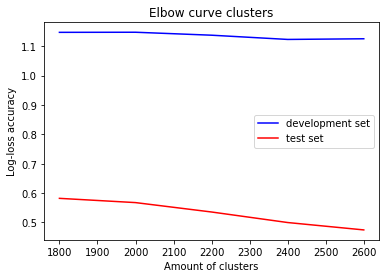

----------------------------------------------------------
this is the C-parameter: 100
this is the gamma-parameter: 0.01
this is the best score: 1.1231799599168217
----------------------------------------------------------
1800
training took 906.1535794734955 seconds
this is the codebooksize: 1800
this is the best score: 1.3882252415621505
2000
training took 934.7117094993591 seconds
2200
training took 1058.6776382923126 seconds
this is the codebooksize: 2200
this is the best score: 1.3848799446159508
2400
training took 1060.4140765666962 seconds
2600
training took 1112.6149957180023 seconds
this is the codebooksize: 2600
this is the best score: 1.3753827075845682


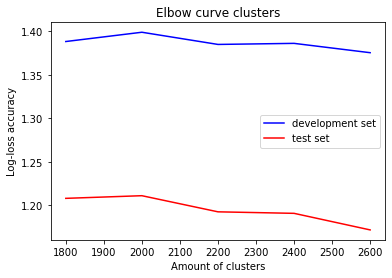

1800
training took 899.6096529960632 seconds
this is the codebooksize: 1800
this is the best score: 1.679333740882567
2000
training took 870.6524019241333 seconds
2200
training took 1022.0529191493988 seconds
2400
training took 989.7219471931458 seconds
2600
training took 1126.1517333984375 seconds
this is the codebooksize: 2600
this is the best score: 1.6756864109016871


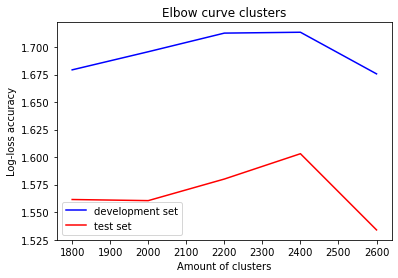

1800
training took 888.742299079895 seconds
this is the codebooksize: 1800
this is the best score: 1.7343067238906569
2000
training took 918.381139755249 seconds
this is the codebooksize: 2000
this is the best score: 1.7301155925433247
2200
training took 1121.4714663028717 seconds
this is the codebooksize: 2200
this is the best score: 1.70197064704599
2400
training took 1106.5079419612885 seconds
2600
training took 1096.2429780960083 seconds


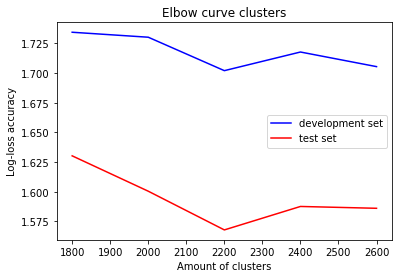

1800
training took 905.4781975746155 seconds
this is the codebooksize: 1800
this is the best score: 1.147163732811594
2000
training took 946.027459859848 seconds
this is the codebooksize: 2000
this is the best score: 1.1317151752451797
2200
training took 899.3694400787354 seconds
this is the codebooksize: 2200
this is the best score: 1.1095721956985316
2400
training took 1108.0564231872559 seconds
2600
training took 1308.704445362091 seconds
this is the codebooksize: 2600
this is the best score: 1.0986783889040665


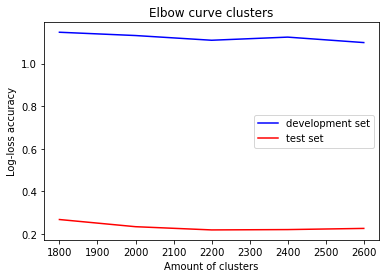

----------------------------------------------------------
this is the C-parameter: 1000
this is the gamma-parameter: 0.01
this is the best score: 1.0986783889040665
----------------------------------------------------------
1800
training took 830.3498666286469 seconds
this is the codebooksize: 1800
this is the best score: 1.122380129908216
2000
training took 959.25861287117 seconds
2200
training took 1106.6592769622803 seconds
2400
training took 1054.6647205352783 seconds
2600
training took 1241.5705461502075 seconds
this is the codebooksize: 2600
this is the best score: 1.1206438450528629


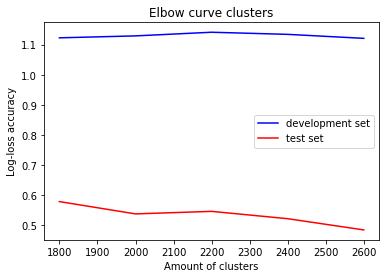

1800
training took 836.1127710342407 seconds
this is the codebooksize: 1800
this is the best score: 1.389228118694382
2000
training took 978.9010243415833 seconds
this is the codebooksize: 2000
this is the best score: 1.3777963218481553
2200
training took 882.3052983283997 seconds
2400
training took 1061.2739086151123 seconds
this is the codebooksize: 2400
this is the best score: 1.3761715836706174
2600
training took 1247.7515015602112 seconds


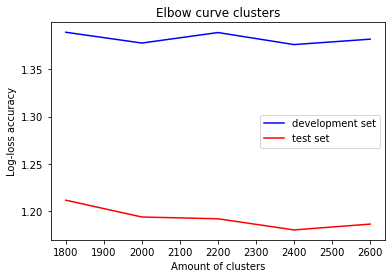

1800
training took 838.4245331287384 seconds
this is the codebooksize: 1800
this is the best score: 1.6965319687858658
2000
training took 949.4590308666229 seconds
this is the codebooksize: 2000
this is the best score: 1.6717628176282027
2200
training took 1073.3506038188934 seconds
2400
training took 1121.9629442691803 seconds
2600
training took 1135.7491400241852 seconds


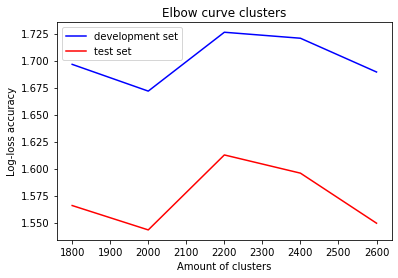

In [15]:
find_optimal_CGAMMA_parameter([ 50, 100, 1000] ,  [1e-2, 1e-3, 1e-4, 1e-5])

### Feature selection using anova test

---------------2.000320413787212
this is the featuresize: 20
this is the best score: 2.000320413787212
---------------1.9387879338976621
this is the featuresize: 40
this is the best score: 1.9387879338976621
---------------1.8714647925461707
this is the featuresize: 60
this is the best score: 1.8714647925461707
---------------1.8524039878427223
this is the featuresize: 80
this is the best score: 1.8524039878427223
---------------1.7838745284315876
this is the featuresize: 100
this is the best score: 1.7838745284315876
---------------1.7644707593233309
this is the featuresize: 120
this is the best score: 1.7644707593233309
---------------1.7420482686043133
this is the featuresize: 140
this is the best score: 1.7420482686043133
---------------1.7286640518815723
this is the featuresize: 160
this is the best score: 1.7286640518815723
---------------1.697789257608828
this is the featuresize: 180
this is the best score: 1.697789257608828
---------------1.6627964812346843
this is the features

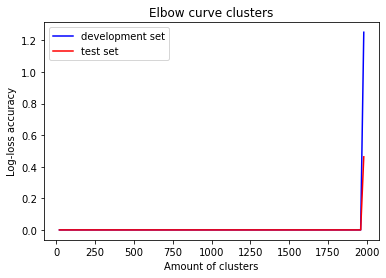

In [34]:
def plot_feature_selection_graph(X, Y, minimum, maximum , step):
    best_score = 99999999
    idx = 0
    for k_param in range (minimum,len(X[0]),step):
        X = train_data
        Y = train_labels
        amount_of_zeroes = (maximum-minimum) // step
        DEV_errors = np.zeros(amount_of_zeroes)
        X_errors = np.zeros(amount_of_zeroes)
        X = SelectKBest(f_classif, k =  k_param).fit_transform(X,Y)
        X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!  
        logreg_best = SVC(C=100,gamma=0.01,probability=True)
        logreg_best.fit(X,Y)
        logistic_regression_dev = logreg_best.predict_proba(X_DEV)
        acc_logreg_dev = log_loss(Y_DEV, logistic_regression_dev)
        logistic_regression_test = logreg_best.predict_proba(X)
        acc_logreg_test = log_loss(Y, logistic_regression_test)
        DEV_errors[idx] = acc_logreg_dev
        X_errors[idx]=acc_logreg_test
        idx = idx + 1
        print("---------------" + str(acc_logreg_dev))
        if acc_logreg_dev < best_score:
                best_score = acc_logreg_dev
                print("this is the featuresize: " + str(k_param))
                print("this is the best score: " + str(best_score))

        


    plt.figure()
    plt.plot(np.arange(minimum,maximum,step),DEV_errors,c='b',label='development set')
    plt.plot(np.arange(minimum,maximum,step),X_errors,c='r',label='test set')
    plt.xlabel("Amount of clusters")
    plt.ylabel("Log-loss accuracy")
    plt.title("Elbow curve clusters")
    plt.legend()
    plt.show()
plot_feature_selection_graph(train_data, train_labels, 20,2000, 20)

## Using the SVM classifier for the cross val curve on parameter C with desired codebooksize

In [92]:
codebook_size = 2000
print(str(codebook_size))


clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)

In [92]:
train_data = []
train_labels = []
for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)


test_data = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)

label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

2000
training took 707.4775609970093 seconds


In [19]:
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
MaxAbsScaler().fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.5,random_state=2) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)
X, X_DEV , Y , Y_DEV = train_test_split(train_data,train_labels,test_size = 0.5,random_state=42) #0.8 split gave us optimal results!
param_range = np.logspace(1, 3, 7)
train_scores, test_scores = validation_curve(
SVC(C=100,gamma=0.01,probability=True), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1 , verbose = 7)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  35 | elapsed:  3.4min remaining: 16.6min
[Parallel(n_jobs=-1)]: Done  12 out of  35 | elapsed:  5.3min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done  18 out of  35 | elapsed:  8.4min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed: 10.3min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed: 13.6min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 15.0min finished


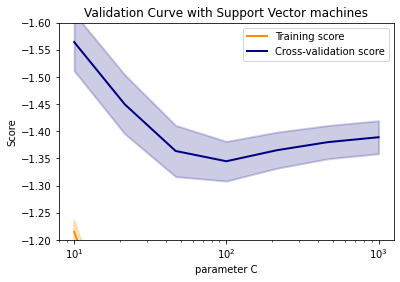

In [20]:
plt.title("Validation Curve with Support Vector machines")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-1.2, -1.6)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

score after standard scaling


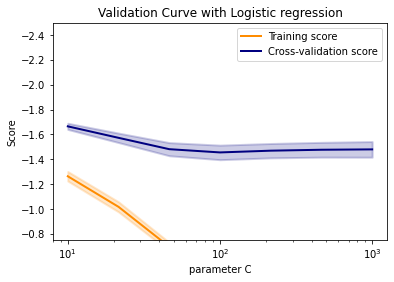

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
print('score after standard scaling')
MinMaxScaler().fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)


param_range = np.logspace(1, 3, 7)
train_scores, test_scores = validation_curve(
SVC(C=100,gamma=0.01,probability=True), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


score after standard scaling


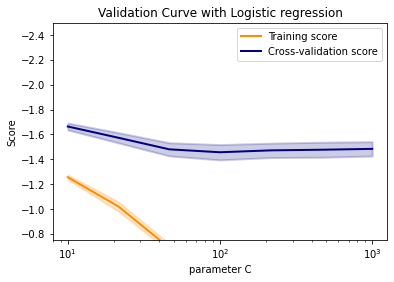

In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
print('score after standard scaling')
MaxAbsScaler().fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)


param_range = np.logspace(1, 3, 7)
train_scores, test_scores = validation_curve(
SVC(C=100,gamma=0.01,probability=True), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


score after standard scaling


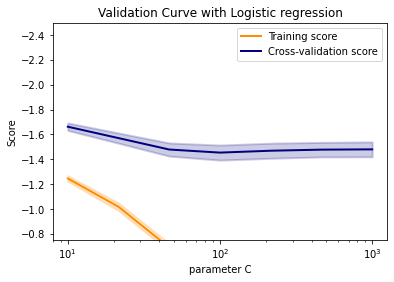

In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
print('score after standard scaling')
StandardScaler().fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)


param_range = np.logspace(1, 3, 7)
train_scores, test_scores = validation_curve(
SVC(C=100,gamma=0.01,probability=True), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


score after standard scaling


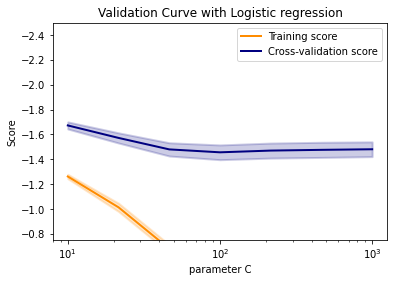

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
print('score after standard scaling')
Normalizer().fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)


param_range = np.logspace(1, 3, 7)
train_scores, test_scores = validation_curve(
SVC(C=100,gamma=0.01,probability=True), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


score after standard scaling


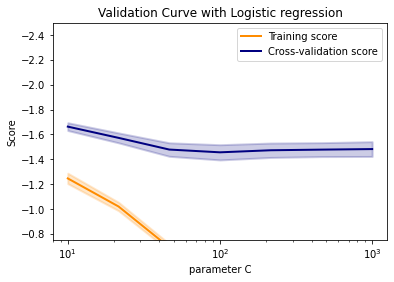

In [43]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
print('score after standard scaling')
StandardScaler().fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)


param_range = np.logspace(1, 3, 7)
train_scores, test_scores = validation_curve(
SVC(C=100,gamma=0.01,probability=True), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


score after standard scaling


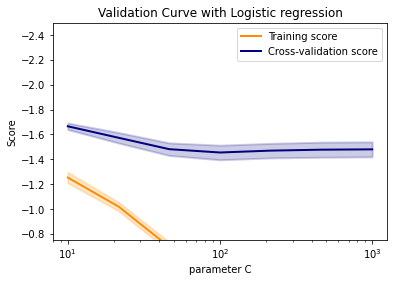

In [44]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
print('score after standard scaling')
QuantileTransformer(output_distribution='uniform').fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)


param_range = np.logspace(1, 3, 7)
train_scores, test_scores = validation_curve(
SVC(C=100,gamma=0.01,probability=True), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


score after standard scaling


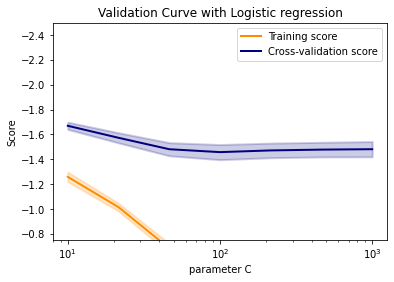

In [45]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
print('score after standard scaling')
QuantileTransformer(output_distribution='normal').fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)


param_range = np.logspace(1, 3, 7)
train_scores, test_scores = validation_curve(
SVC(C=100,gamma=0.01,probability=True), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

score after standard scaling


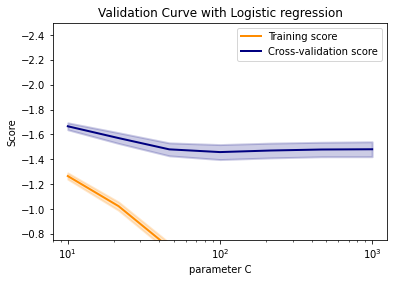

In [46]:


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
print('score after standard scaling')
PowerTransformer(method='yeo-johnson').fit_transform(X)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)


param_range = np.logspace(1, 3, 7)
train_scores, test_scores = validation_curve(
SVC(C=100,gamma=0.01,probability=True), X_DEV,Y_DEV, param_name="C", param_range=param_range,
    scoring=LogLoss, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic regression")
plt.xlabel("parameter C")
plt.ylabel("Score")
plt.ylim(-0.75, -2.5)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


In [25]:
from sklearn.model_selection import StratifiedKFold
X = train_data
pred_test_full = 0
Y = train_labels    
X = pd.DataFrame(X) 
Y = pd.DataFrame(Y)
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
i = 0
param = {'C':[900, 100 , 1100],
        'gamma':[0.0005,0.001,0.0015]}
for train_index,test_index in kf.split(X,Y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = Y.loc[train_index],Y.loc[test_index]
    model = GridSearchCV(SVC(C=1000,gamma=0.001,probability=True),param, cv=3, scoring=LogLoss,iid=True)
    model.fit(xtr, ytr.values.ravel())
    print (model.best_params_)
    pred=model.predict_proba(xvl)
    print('logloss_score',log_loss(yvl,pred))
    pred_test = model.predict_proba(test_data)
    pred_test_full +=pred_test
    i+=1


0 of kfold 5


C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'C': 1100, 'gamma': 0.0015}
logloss_score 1.0998988298276409

1 of kfold 5


C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'C': 1100, 'gamma': 0.0015}
logloss_score 1.0643219218393374

2 of kfold 5


C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'C': 1100, 'gamma': 0.0015}
logloss_score 1.046349402605734

3 of kfold 5


C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'C': 1100, 'gamma': 0.0015}
logloss_score 1.0714031461764606

4 of kfold 5


C:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


{'C': 1100, 'gamma': 0.0015}
logloss_score 1.1058868144050689


In [39]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.7,random_state=2) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)



SVC_best = Pipeline([('feature_select' , SelectKBest(f_classif, k =  1900)),
                        ('clf' , SVC(C=100,gamma=0.01,probability=True))])
param_grid = {
    'clf__C': [90,100,110],
}

split_strat = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
SVC_best = GridSearchCV(SVC_best, param_grid = param_grid,  cv=split_strat)

In [81]:
SVC_best = SVC(C=100,gamma=0.01,probability=True)
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
MaxAbsScaler().fit_transform(X)
#test_data = f_class.transform(test_data)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.8,random_state=2) #0.8 split gave us optimal results!
count_class_golden_retriever = 442
count_class_fox = 442
sm = SMOTE(sampling_strategy = {2: count_class_fox , 4: count_class_golden_retriever},random_state=2)
print("done")
X_DEV, Y_DEV = sm.fit_sample(X_DEV, Y_DEV)
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)

SVC_best.fit(X_DEV,Y_DEV)

SVC_dev = SVC_best.predict_proba(X)
acc_SVC_dev = log_loss(Y, SVC_dev)

done


In [73]:
test_data = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)
    

In [82]:

SVC_test = SVC_best.predict_proba(test_data)

In [83]:
print("current log_loss: " + str(acc_SVC_dev))

current log_loss: 1.2166566557790883


Confusion matrix, without normalization
[[79  7  0  4  0 14  1  0  2  1  0  0]
 [16 39  3  5  1 20  0  2  2  0  0  2]
 [ 2  0 23  4  4  0  0  5  0  6  1  2]
 [ 4  3  8 54  1  4  0 12  0  2  4  2]
 [ 0  2  0  5  2  1  0  2  0  0  0  0]
 [11 16  0  6  0 59  0  0  0  0  0  0]
 [ 0  0  1  1  0  0 14  3  0  0  0  2]
 [ 0  2  7  4  2  0  0 52  5  4  0  3]
 [ 1  0  6  5  1  0  0  9 29 10  3  5]
 [ 5  2 12  3  0  1  0  5 10 50  7  2]
 [ 1  1  4  3  0  0  0  0  1  4 28  0]
 [ 0  2  1  4  0  0  0  9  0  3  1 37]]
Normalized confusion matrix
[[0.73148148 0.06481481 0.         0.03703704 0.         0.12962963
  0.00925926 0.         0.01851852 0.00925926 0.         0.        ]
 [0.17777778 0.43333333 0.03333333 0.05555556 0.01111111 0.22222222
  0.         0.02222222 0.02222222 0.         0.         0.02222222]
 [0.04255319 0.         0.4893617  0.08510638 0.08510638 0.
  0.         0.10638298 0.         0.12765957 0.0212766  0.04255319]
 [0.04255319 0.03191489 0.08510638 0.57446809 0.0106383  0.0

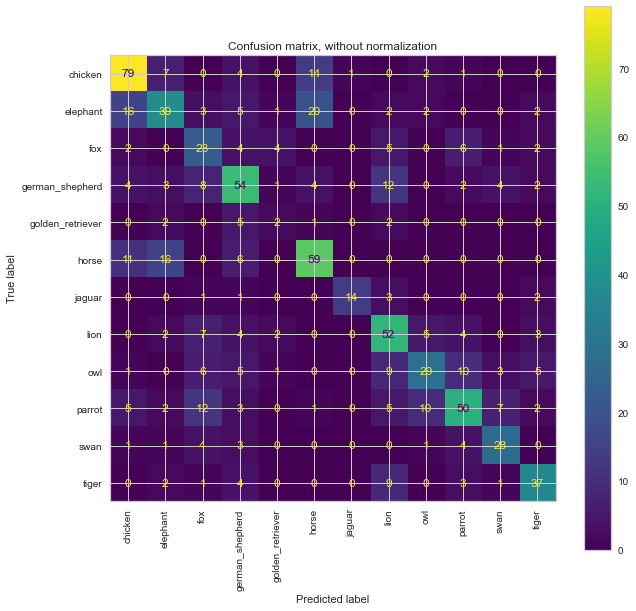

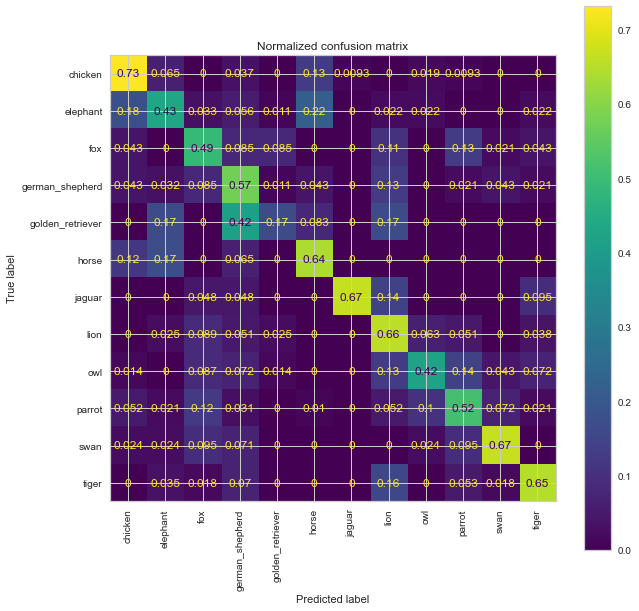

In [84]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = plot_confusion_matrix(SVC_best, X, Y,
                                 display_labels=label_strings,
                                 xticks_rotation='vertical',
                                 normalize=normalize,ax=ax)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

## Using Random-forrest classifier

### Use randomsearch cv to find optimal parameters

In [261]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Hyperparameter Optimization
rf = RandomForestClassifier()
X, X_DEV , Y , Y_DEV = train_test_split(train_data,train_labels,test_size = 0.8,random_state=42) #0.8 split gave us optimal results!
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Run the grid search
grid_obj =  RandomizedSearchCV(estimator = rf,scoring=LogLoss, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
grid_obj = grid_obj.fit(X_DEV,Y_DEV)
print("tuned hpyerparameters :(best parameters) ",grid_obj.best_params_)
print("accuracy :",grid_obj.best_score_)
rf = grid_obj.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 73.0min finished


tuned hpyerparameters :(best parameters)  {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}
accuracy : -1.6933992316750697


In [289]:
X = train_data
Y = train_labels

ch2 = SelectKBest(chi2, k =  1920)

X = ch2.fit_transform(X,Y)
rf = RandomForestClassifier(n_estimators = 1400, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', max_depth = 40, bootstrap =  False, n_jobs = -1)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.7,random_state=42) #0.8 split gave us optimal results!


rf.fit(X_DEV,Y_DEV)
Forest_prediction = rf.predict_proba(test_data)
y_pred=rf.predict(X)
decision_forrest_train = rf.predict_proba(X)
acc_rf = log_loss(Y, decision_forrest_train)
print("current log loss: " + str(acc_rf))

ValueError: Number of features of the model must match the input. Model n_features is 1920 and input n_features is 2000 

Confusion matrix, without normalization
[[68  3  0  0  0 14  0  1  4  1  0  0]
 [31 14  1  1  0 31  0  7  0  1  1  3]
 [ 4  1  3 16  0  1  0 28  3  4  0  0]
 [16  4  0 40  0  6  0 14  3  3  1  3]
 [ 2  0  1  7  0  0  0  2  0  1  1  0]
 [21  1  0  0  0 58  0  0  0  0  0  0]
 [ 2  0  0  1  0  0  1  1  0  0  0 10]
 [ 5  0  3  9  0  0  0 46  5  0  0  3]
 [ 7  2  0  6  0  0  0 10 20 11  1 15]
 [ 6  3  0  7  0  2  0  4  5 52  7  5]
 [ 1  1  0  0  0  1  0  0  2 10 25  2]
 [ 4  0  0  5  0  0  0 15  3  7  1 57]]
Normalized confusion matrix
[[0.74725275 0.03296703 0.         0.         0.         0.15384615
  0.         0.01098901 0.04395604 0.01098901 0.         0.        ]
 [0.34444444 0.15555556 0.01111111 0.01111111 0.         0.34444444
  0.         0.07777778 0.         0.01111111 0.01111111 0.03333333]
 [0.06666667 0.01666667 0.05       0.26666667 0.         0.01666667
  0.         0.46666667 0.05       0.06666667 0.         0.        ]
 [0.17777778 0.04444444 0.         0.44444444 0.    

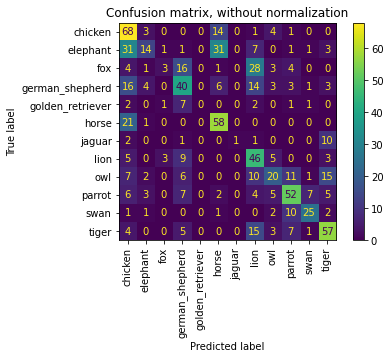

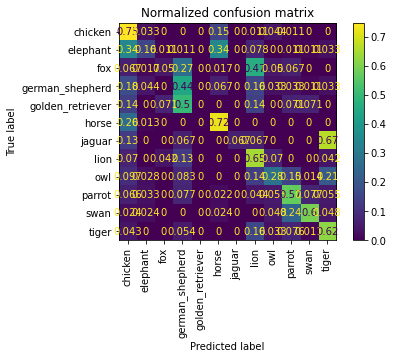

In [268]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = plot_confusion_matrix(rf, X, Y,
                                 display_labels=label_strings,
                                 xticks_rotation='vertical',
                                 normalize=normalize
                                    ax=ax)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

## Using ADA-boost classifier

### Finetuning ADA-boost classifier (with decision tree)

In [291]:
from sklearn.ensemble import AdaBoostClassifier

# encode all test images 
test_data = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)
    
ada=AdaBoostClassifier()
search_grid={'n_estimators':[3,9,81,273,800],'learning_rate':[.001,0.01,.1, 1]}
search=GridSearchCV(estimator=ada,param_grid=search_grid,scoring=LogLoss,n_jobs=-1)
X = train_data
Y = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.7,random_state=42) #0.8 split gave us optimal results!


search.fit(X_DEV,Y_DEV)
print(search.best_params_)

In [62]:
from sklearn.ensemble import AdaBoostClassifier
X = train_data
Y = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.5,random_state=42) #0.8 split gave us optimal results!
search = AdaBoostClassifier(SVC(C=100,gamma=0.01,probability=True) , n_estimators=5 , learning_rate = 4.0 )
search.fit(X_DEV,Y_DEV)

Forest_prediction = search.predict_proba(test_data)
y_pred=search.predict(X)
ada_forrest_train = search.predict_proba(X)
acc_rf = log_loss(Y, ada_forrest_train)
print("current log loss: " + str(acc_rf))

KeyboardInterrupt: 

In [ ]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = plot_confusion_matrix(search, X, Y,
                                 display_labels=label_strings,
                                 xticks_rotation='vertical',
                                 normalize=normalize , ax=ax)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

### Finetuning XGB-Boost classifier (using random search to get a general idea)

In [20]:
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from xgboost import XGBClassifier
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [74]:
#https://www.kaggle.com/felipefiorini/xgboost-hyper-parameter-tuning
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]




def hyperParameterTuning(X_train, y_train):
    params ={'n_estimators': stats.randint(150, 2000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.6, 0.9),
              'max_depth': [5, 6, 7, 8, 9 , 10],
              'reg_alpha' : stats.uniform(1e-5 , 1e-3)
             'scale_pos_weight': stats.uniform(1 ,100),
              'colsample_bytree': stats.uniform(0, 0.9),
              'min_child_weight': [1, 2, 3, 4 , 5]
             }

    xgb_model = XGBClassifier(objective = "multi:softprob", eval_metric = "mlogloss")

    gsearch = RandomizedSearchCV(xgb_model, param_distributions = params,scoring=LogLoss, n_iter = 90, verbose = 60, n_jobs = -1 , cv = 3)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

X = train_data
Y = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.4,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)
hyperParameterTuning(X_DEV_arr,Y_DEV_arr)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6

KeyboardInterrupt: 

In [78]:
X = train_data
Y = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.8,random_state=42) #0.8 split gave us optimal results!
#X = SelectKBest(chi2, k =  1920).fit_transform(X,Y)
#sm = SMOTE(random_state=2)
#X_DEV, Y_DEV = sm.fit_sample(X_DEV, Y_DEV)
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)



search = XGBClassifier(
        objective = "multi:softprob",
        eval_metric = "mlogloss",
        colsample_bytree = 0.8281,
        scale_pos_weight = 1,
        learning_rate = 0.1371,
        max_depth = 7,
        min_child_weight = 3,
        n_estimators = 506,
        subsample = 0.855,
        verbosity = 1)

search.fit(X_DEV_arr,Y_DEV_arr)
test_data_arr = np.array(test_data)
Forest_prediction = search.predict_proba(test_data_arr)
y_pred=search.predict(X_arr)
ada_forrest_train = search.predict_proba(X_arr)
acc_rf = log_loss(Y, ada_forrest_train)
print("current log loss: " + str(acc_rf))

C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


current log loss: 1.3107638110226312


Confusion matrix, without normalization
[[67  9  0  0  0 11  1  0  0  2  0  1]
 [17 41  1  1  0 20  0  6  1  0  2  1]
 [ 2  2 22 12  0  1  0 12  3  5  0  1]
 [ 5  2  3 59  0  3  0  6  0  5  4  3]
 [ 1  2  0  6  2  0  0  1  1  0  1  0]
 [19 12  0  1  0 48  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  5  1  1  0  0  7]
 [ 0  1  6  6  1  0  0 48  4  3  0  2]
 [ 4  1  3  2  0  0  1  5 32  8  3 13]
 [ 1  2  2  5  0  2  0  3 14 50  7  5]
 [ 1  2  0  3  0  0  0  0  0  8 26  2]
 [ 2  1  2  6  0  0  0 10  5  5  1 60]]
Normalized confusion matrix
[[0.73626374 0.0989011  0.         0.         0.         0.12087912
  0.01098901 0.         0.         0.02197802 0.         0.01098901]
 [0.18888889 0.45555556 0.01111111 0.01111111 0.         0.22222222
  0.         0.06666667 0.01111111 0.         0.02222222 0.01111111]
 [0.03333333 0.03333333 0.36666667 0.2        0.         0.01666667
  0.         0.2        0.05       0.08333333 0.         0.01666667]
 [0.05555556 0.02222222 0.03333333 0.65555556 0.    

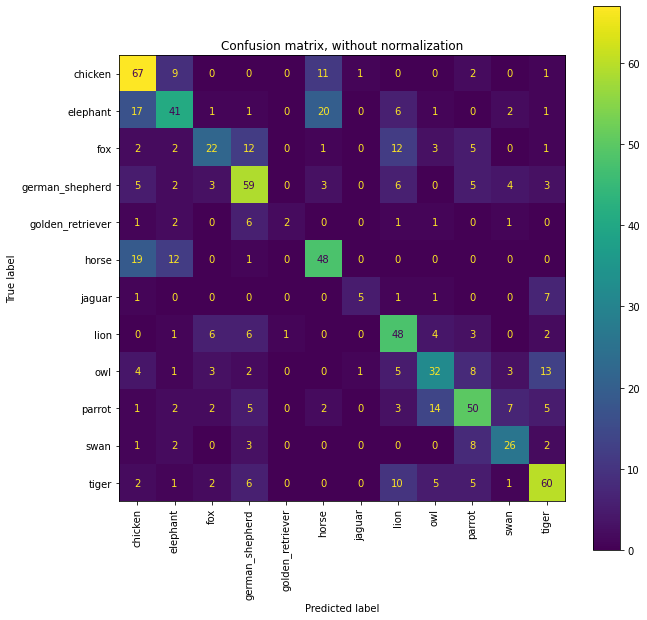

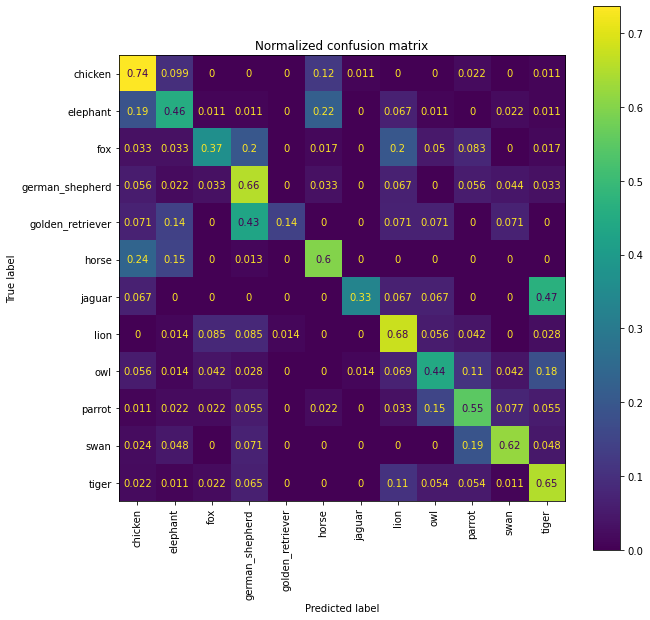

In [79]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = plot_confusion_matrix(search, X_arr, Y_arr,
                                 display_labels=label_strings,
                                 xticks_rotation='vertical',
                                 normalize=normalize , ax = ax)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    

plt.show()

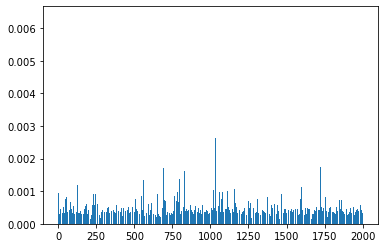

In [471]:
plt.bar(range(len(search.feature_importances_)) , search.feature_importances_)
plt.show()

### Finetuning XGB-Boost classifier (cross val score for amount estimators) Using info we have gained 

In [460]:
#https://www.analiticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)

param_range = [2,4,8,16,32,64,128,256,512,1024,2048 , 4096 , 8128] #I know


train_scores, test_scores = validation_curve(XGBClassifier(
        objective = "multi:softprob",
        eval_metric = "mlogloss",
        colsample_bytree = 0.8,
        scale_pos_weight = 1,
        learning_rate = 0.01,
        reg_alpha = 1e-4,
        max_depth = 6,
        min_child_weight = 2,
        n_estimators = 2000,
        subsample = 0.8,
        verbosity = 1), Train_data_copy,train_labels_copy,scoring=LogLoss, param_name="n_estimators", param_range=param_range, n_jobs=-1 , verbose= 40)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  65 | elapsed:   28.9s remaining: 15.2min
[Parallel(n_jobs=-1)]: Done   4 out of  65 | elapsed:  1.6min remaining: 24.7min
[Parallel(n_jobs=-1)]: Done   6 out of  65 | elapsed:  6.7min remaining: 65.5min
[Parallel(n_jobs=-1)]: Done   8 out of  65 | elapsed: 25.8min remaining: 183.5min
[Parallel(n_jobs=-1)]: Done  10 out of  65 | elapsed: 96.6min remaining: 531.3min
[Parallel(n_jobs=-1)]: Done  12 out of  65 | elapsed: 97.2min remaining: 429.3min
[Parallel(n_jobs=-1)]: Done  14 out of  65 | elapsed: 99.5min remaining: 362.4min
[Parallel(n_jobs=-1)]: Done  16 out of  65 | elapsed: 109.7min remaining: 335.9min
[Parallel(n_jobs=-1)]: Done  18 out of  65 | elapsed: 148.2min remaining: 387.0min
[Parallel(n_jobs=-1)]: Done  20 out of  65 | elapsed: 198.2min remaining: 446.0min
[Parallel(n_jobs=-1)]: Done  22 out of  65 | elapsed: 311.6min remaining: 609.1min
[Parallel(n_jobs=-1)]

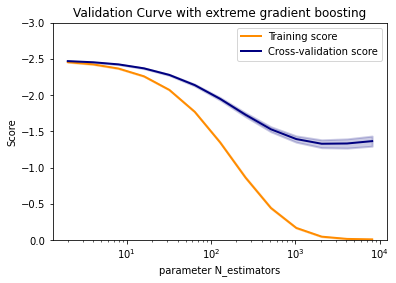

In [461]:
plt.title("Validation Curve with extreme gradient boosting")
plt.xlabel("parameter N_estimators")
plt.ylabel("Score")
plt.ylim(0, -3)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()





### Finetuning XGB-Boost classifier gridsearch for max_depth and min child weight

In [ ]:

X = train_data
Y = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)

param_range = range(2,20,2)
for i in range (1,10):
    print("Cross-val curve for min child weight = " + str(i))
    train_scores, test_scores = validation_curve(XGBClassifier(
            objective = "multi:softprob",
            eval_metric = "mlogloss",
            colsample_bytree = 0.8,
            scale_pos_weight = 1,
            verbosity = 2,
            learning_rate = 0.068,
            max_depth = 2,
            min_child_weight = i,
            n_estimators = 400,
            subsample = 0.8), Train_data_copy,train_labels_copy, param_name="max_depth",scoring=LogLoss, param_range=param_range,cv = 3, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Validation Curve with extreme gradient boosting")
    plt.xlabel("parameter max_depth")
    plt.ylabel("Score")
    plt.ylim(-1.5, -2)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()


### Finetuning XGB-Boost classifier gamma parameter

In [389]:
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
param_range = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]


train_scores, test_scores = validation_curve(XGBClassifier(
        objective = "multi:softprob",
        eval_metric = "mlogloss",
        colsample_bytree = 0.8,
        scale_pos_weight = 1,
        learning_rate = 0.068,
        max_depth = 6,
        gamma = 0,
        min_child_weight = 2,
        n_estimators = 200,
        subsample = 0.8), X_DEV_arr,Y_DEV_arr,scoring=LogLoss, param_name="gamma", param_range=param_range, n_jobs=-1, verbose=True)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  55 | elapsed: 21.6min remaining: 44.5min
[Parallel(n_jobs=-1)]: Done  37 out of  55 | elapsed: 44.2min remaining: 21.5min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed: 62.8min finished


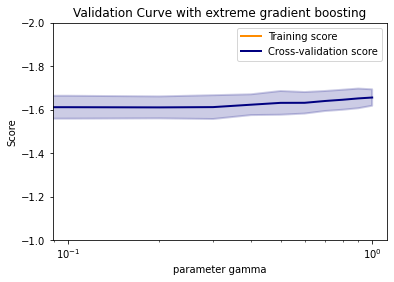

In [391]:
plt.title("Validation Curve with extreme gradient boosting")
plt.xlabel("parameter gamma")
plt.ylabel("Score")
plt.ylim(-1, -2)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Finetuning XGB-Boost classifier subsample and colsample

Cross-val curve for subsample = 0.1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  30 | elapsed:   28.2s remaining: 13.7min
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   28.6s remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:  1.2min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  1.2min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  1.9min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  1.9min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:  2.5min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  2.5min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed:  3.6min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  3.6min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  4.0min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  23 o

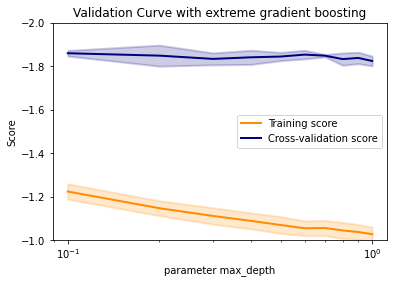

Cross-val curve for subsample = 0.2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  30 | elapsed:   43.2s remaining: 20.9min
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   44.4s remaining:  6.7min
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:  2.2min remaining: 10.9min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  2.2min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  3.4min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  3.5min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:  4.5min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  4.5min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed:  6.1min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  6.1min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  6.7min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  23 o

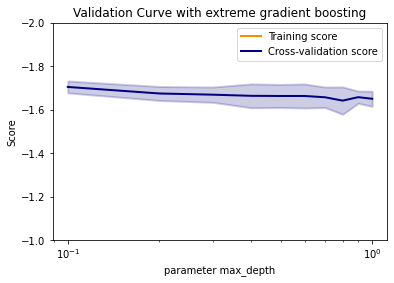

Cross-val curve for subsample = 0.3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  30 | elapsed:  1.0min remaining: 30.3min
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  1.1min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:  3.1min remaining: 15.7min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  3.2min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  4.7min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  4.8min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:  6.1min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  6.1min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed:  8.5min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  8.5min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:  9.3min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  23 o

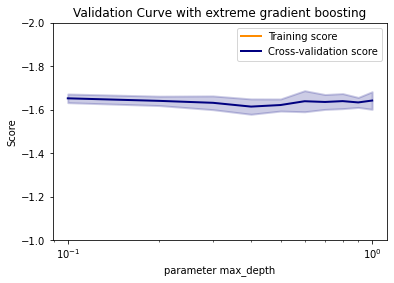

Cross-val curve for subsample = 0.4


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  30 | elapsed:  1.1min remaining: 33.0min
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  1.2min remaining: 10.5min
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:  3.8min remaining: 18.9min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  3.8min remaining: 12.6min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  6.0min remaining: 14.0min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  6.0min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:  7.8min remaining: 10.3min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  7.9min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed: 11.2min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 11.3min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed: 12.2min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  23 o

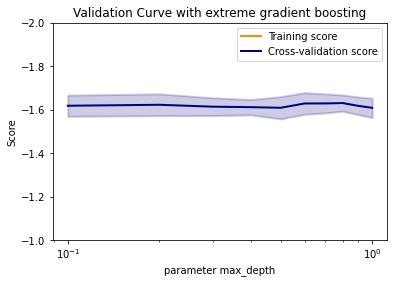

Cross-val curve for subsample = 0.5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  30 | elapsed:  1.3min remaining: 38.8min
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  1.4min remaining: 12.2min
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:  4.1min remaining: 20.5min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  4.2min remaining: 13.7min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  6.7min remaining: 15.7min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  6.8min remaining: 11.7min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:  8.8min remaining: 11.6min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  8.9min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed: 12.4min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 12.4min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed: 13.7min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  23 o

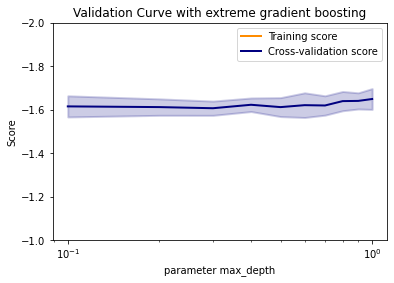

Cross-val curve for subsample = 0.6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  30 | elapsed:  1.4min remaining: 41.3min
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  1.4min remaining: 12.9min
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:  4.3min remaining: 21.5min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  4.3min remaining: 14.3min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  6.7min remaining: 15.6min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  6.7min remaining: 11.6min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:  8.9min remaining: 11.6min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  8.9min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed: 12.4min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 12.5min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed: 13.7min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  23 o

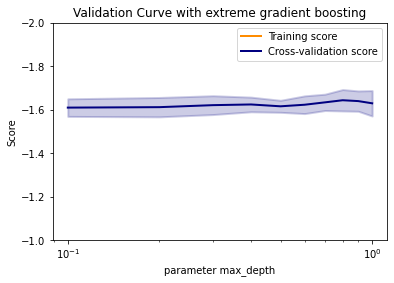

Cross-val curve for subsample = 0.7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  30 | elapsed:  1.4min remaining: 41.0min
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  1.4min remaining: 12.8min
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:  4.2min remaining: 20.9min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  4.2min remaining: 13.9min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  6.9min remaining: 16.2min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  6.9min remaining: 12.0min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:  9.1min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  9.1min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed: 12.7min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 12.7min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed: 13.9min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  23 o

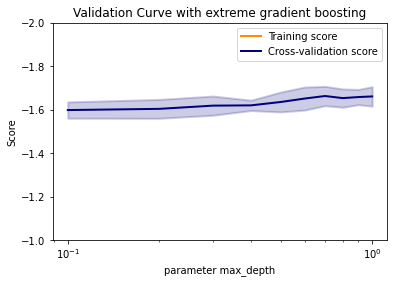

Cross-val curve for subsample = 0.8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  30 | elapsed:  1.5min remaining: 42.1min
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  1.5min remaining: 13.1min
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:  4.8min remaining: 24.1min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  4.8min remaining: 15.9min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  7.2min remaining: 16.8min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  7.2min remaining: 12.5min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:  9.2min remaining: 12.0min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  9.2min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed: 12.6min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 12.7min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed: 13.8min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  23 o

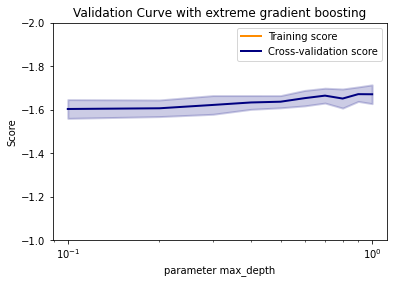

Cross-val curve for subsample = 0.9


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  30 | elapsed:  1.3min remaining: 38.0min
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  1.3min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:  4.1min remaining: 20.6min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  4.2min remaining: 13.6min
[Parallel(n_jobs=-1)]: Done   9 out of  30 | elapsed:  6.7min remaining: 15.6min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  6.7min remaining: 11.6min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:  8.9min remaining: 11.6min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  8.9min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done  17 out of  30 | elapsed: 13.3min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 13.3min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed: 14.9min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done  23 o

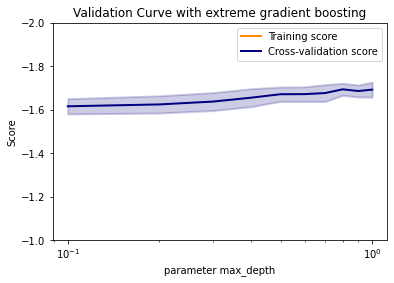

In [453]:

X = train_data
Y = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)




param_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for i in range (1,10):
    sub_sample = i / 10
    print("Cross-val curve for subsample = " + str(sub_sample))
    train_scores, test_scores = validation_curve(XGBClassifier(
            objective = "multi:softprob",
            eval_metric = "mlogloss",
            colsample_bytree = 0.8,
            subsample=sub_sample,
            scale_pos_weight = 1,
            gamma = 0,
            learning_rate = 0.068,
            max_depth = 6,
            min_child_weight = 2,
            n_estimators = 200), X_DEV_arr,Y_DEV_arr, param_name="colsample_bytree",scoring=LogLoss, param_range=param_range,cv = 3, n_jobs=-1 , verbose = 20)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title("Validation Curve with extreme gradient boosting")
    plt.xlabel("parameter max_depth")
    plt.ylabel("Score")
    plt.ylim(-1, -2)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

### Finetuning XGB-Boost classifier regularization parameters

In [454]:
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
param_range = [1e-5 , 1e-4 , 1e-3 , 1e-2 , 0.1 , 1 , 10 , 100 , 1000]


train_scores, test_scores = validation_curve(XGBClassifier(
        objective = "multi:softprob",
        eval_metric = "mlogloss",
        colsample_bytree = 0.8,
        scale_pos_weight = 1,
        learning_rate = 0.068,
        reg_alpha = 1,
        max_depth = 6,
        gamma = 0,
        min_child_weight = 2,
        n_estimators = 200,
        subsample = 0.8), X_DEV_arr,Y_DEV_arr,scoring=LogLoss, param_name="reg_alpha", param_range=param_range, n_jobs=-1, verbose=True)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

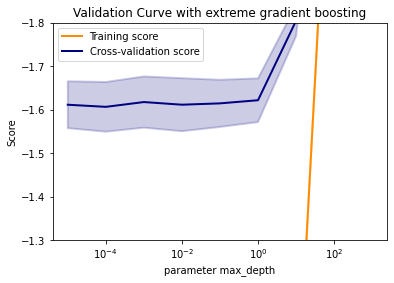

In [456]:
plt.title("Validation Curve with extreme gradient boosting")
plt.xlabel("parameter max_depth")
plt.ylabel("Score")
plt.ylim(-1.3, -1.8)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Finetuning XGB-Boost classifier scale-pos-weight to adress class imbalance

In [75]:
X = train_data
Y = train_labels
Train_data_copy = train_data
train_labels_copy = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.3,random_state=42) #0.8 split gave us optimal results!
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)
Train_data_copy = np.array(Train_data_copy)
train_labels_copy = np.array(train_labels_copy)
param_range = [1 , 2 , 3 , 4 , 8 , 16 , 32 , 64 , 128 , 256]


train_scores, test_scores = validation_curve(XGBClassifier(
        objective = "multi:softprob",
        eval_metric = "mlogloss",
        colsample_bytree = 0.8,
        scale_pos_weight = 1,
        learning_rate = 0.068,
        reg_alpha = 1e-4,
        max_depth = 6,
        gamma = 0,
        min_child_weight = 2,
        n_estimators = 200,
        subsample = 0.8), X_DEV_arr,Y_DEV_arr,scoring=LogLoss, param_name="scale_pos_weight", param_range=param_range, n_jobs=-1, verbose=10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:  4.5min remaining: 70.9min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed: 13.1min remaining: 59.6min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 17.2min remaining: 40.0min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed: 25.3min remaining: 35.0min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed: 29.8min remaining: 25.4min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 38.2min remaining: 19.7min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 42.3min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 50.5min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 52.6min finished


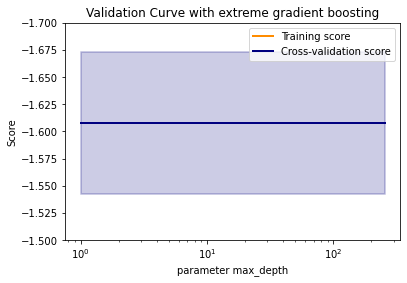

In [77]:
plt.title("Validation Curve with extreme gradient boosting")
plt.xlabel("parameter max_depth")
plt.ylabel("Score")
plt.ylim(-1.5, -1.7)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Finetuning XGB-Boost classifier using smaller learning rate

In [457]:
X = train_data
Y = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.5,random_state=42) #0.8 split gave us optimal results!
#X = SelectKBest(chi2, k =  1920).fit_transform(X,Y)
#sm = SMOTE(random_state=2)
#X_DEV, Y_DEV = sm.fit_sample(X_DEV, Y_DEV)
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)



search = XGBClassifier(
        objective = "multi:softprob",
        eval_metric = "mlogloss",
        colsample_bytree = 0.8,
        scale_pos_weight = 1,
        learning_rate = 0.01,
        reg_alpha = 1e-4,
        max_depth = 6,
        min_child_weight = 2,
        n_estimators = 2000,
        subsample = 0.8,
        verbosity = 1)

search.fit(X_DEV_arr,Y_DEV_arr)
test_data_arr = np.array(test_data)
Forest_prediction = search.predict_proba(test_data_arr)
y_pred=search.predict(X_arr)
ada_forrest_train = search.predict_proba(X_arr)
acc_rf = log_loss(Y, ada_forrest_train)
print("current log loss: " + str(acc_rf))

C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:30:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


current log loss: 1.8286660475520908


Confusion matrix, without normalization
[[193  12   0   8   0  35   1   9   2   5   2   3]
 [ 67  46   1  10   0  79   0  13   1   2   4   2]
 [ 13   3  16  27   0   3   0  38   4   5   2   5]
 [ 17   2   6 104   0  15   0  40   4  10   6  18]
 [  5   1   2  15   1   2   0   6   0   2   2   0]
 [ 51  23   0   3   0 148   0   1   0   5   1   0]
 [  1   0   0   4   0   0   9   7   0   1   0  17]
 [ 10   1   3  20   1   0   0 121   7   8   0  11]
 [  9   1   4  11   0   1   1  23  36  38   3  51]
 [ 14   4   8  30   1   5   1  11   5 102  15  21]
 [  2   0   5  10   0   4   0   1   3  20  58   3]
 [ 10   2   4  10   1   1   0  31   7   9   2 121]]
Normalized confusion matrix
[[0.71481481 0.04444444 0.         0.02962963 0.         0.12962963
  0.0037037  0.03333333 0.00740741 0.01851852 0.00740741 0.01111111]
 [0.29777778 0.20444444 0.00444444 0.04444444 0.         0.35111111
  0.         0.05777778 0.00444444 0.00888889 0.01777778 0.00888889]
 [0.11206897 0.02586207 0.13793103 0.23275862

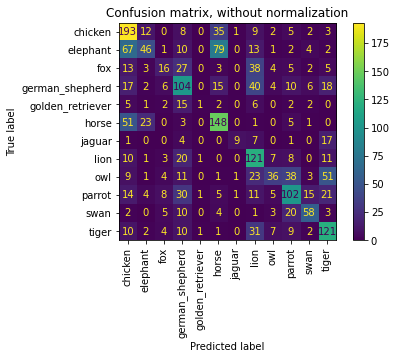

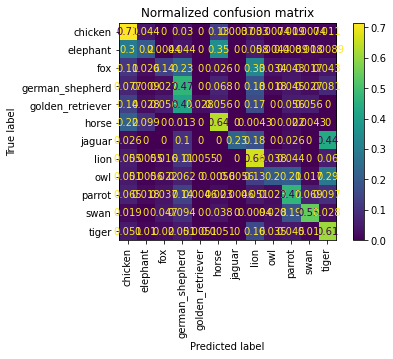

In [458]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(search, X_arr, Y_arr,
                                 display_labels=label_strings,
                                 xticks_rotation='vertical',
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    

plt.show()

### Final steps using voting classifier

In [22]:
from sklearn.ensemble import VotingClassifier

In [94]:
##clf 1 will become optimized svm
##clf 2 will become optimized logreg
##clf 3 will become optimized xboost
for w1 in range(1,5):
    for w2 in range(1,5):
        for w3 in range(1,5):
            X = train_data
            Y = train_labels
            X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.5,random_state=42) #0.8 split gave us optimal results!
            #X = SelectKBest(chi2, k =  1920).fit_transform(X,Y)
            #sm = SMOTE(random_state=2)
            #X_DEV, Y_DEV = sm.fit_sample(X_DEV, Y_DEV)
            X_DEV_arr = np.array(X_DEV)
            Y_DEV_arr = np.array(Y_DEV)
            X_arr = np.array(X)
            Y_arr = np.array(Y)
            clf1 = SVC(C=100 , gamma = 0.01 , probability = True)
            clf2 = LogisticRegression(C= 8 , max_iter= 2000 )
            clf3 = XGBClassifier(objective = "multi:softprob",
                                    eval_metric = "mlogloss",
                                    colsample_bytree = 0.8,
                                    scale_pos_weight = 1,
                                    learning_rate = 0.01,
                                    reg_alpha = 1e-4,
                                    max_depth = 6,
                                    min_child_weight = 2,
                                    n_estimators = 2048,
                                    subsample = 0.8,
                                    verbosity = 1)
            eclf = VotingClassifier(estimators=[('svm', clf1), ('lr', clf2), ('xgb', clf3)],voting='soft',weights=[4,4,2])
            eclf.fit(X_DEV_arr,Y_DEV_arr)
            test_data_arr = np.array(test_data)
            Forest_prediction = eclf.predict_proba(test_data_arr)
            y_pred=eclf.predict(X_arr)
            ada_forrest_train = eclf.predict_proba(X_arr)
            acc_rf = log_loss(Y, ada_forrest_train)
            print("-------------------------------------------------")
            print("w1:" + str(4))
            print("w1:" + str(4))
            print("w1:" + str(2))
            print("current log loss: " + str(acc_rf))

C:\Users\Gebruiker\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:59:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


-------------------------------------------------
w1:4
w1:4
w1:2
current log loss: 1.2541271458215506


KeyboardInterrupt: 

In [54]:
#w1= 3 , w2 = 3 , w3 = 2 gave an optimal score of 1.24
# encode all test images 
test_data = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)
    
    

In [23]:
from yellowbrick.model_selection import LearningCurve
from imblearn.over_sampling import SMOTE , BorderlineSMOTE , ADASYN 
X = train_data
Y = train_labels




clf1 = SVC(C=1100 , gamma = 0.0015 , probability = True)
clf2 = LogisticRegression(C= 20 , max_iter= 2000 )
clf3 = XGBClassifier(objective = "multi:softprob",
                        eval_metric = "mlogloss",
                        colsample_bytree = 0.5,
                        scale_pos_weight = 1,
                        learning_rate = 0.01,
                        reg_alpha = 1e-4,
                        max_depth = 6,
                        min_child_weight = 2,
                        n_estimators = 2048,
                        subsample = 0.8,
                        verbosity = 1)
eclf = VotingClassifier(estimators=[('svm', clf1), ('lr', clf2), ('xgb', clf3)],voting='soft',weights=[3,4,3] , n_jobs = -1)


sizes = np.linspace(0.3, 1.0, 5)



In [25]:
def plot_feature_selection_graph_voting(X, Y, minimum, maximum , step):
    best_score = 99999999
    idx = 0
    amount_of_zeroes = (maximum-minimum) // step
    DEV_errors = np.zeros(amount_of_zeroes)
    X_errors = np.zeros(amount_of_zeroes)
    for k_param in range (minimum,len(X[0]),step):
        X = train_data
        Y = train_labels
        

        X = SelectKBest(f_classif, k =  k_param).fit_transform(X,Y)
        X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.8,random_state=42) #0.8 split gave us optimal results!
        count_class_golden_retriever = 459
        count_class_fox = 459
        sm = SMOTE(sampling_strategy = {2: count_class_fox , 4: count_class_golden_retriever},random_state=2)
        print("done")
        X_DEV, Y_DEV = sm.fit_sample(X_DEV, Y_DEV)
        clf1 = SVC(C=100 , gamma = 0.01 , probability = True)
        clf2 = LogisticRegression(C= 8 , max_iter= 2000 )
        clf3 = XGBClassifier(objective = "multi:softprob",
                        eval_metric = "mlogloss",
                        colsample_bytree = 0.5,
                        scale_pos_weight = 1,
                        learning_rate = 0.01,
                        reg_alpha = 1e-4,
                        max_depth = 6,
                        min_child_weight = 2,
                        n_estimators = 2048,
                        subsample = 0.8,
                        verbosity = 1)
        logreg_best = VotingClassifier(estimators=[('svm', clf1), ('lr', clf2), ('xgb', clf3)],voting='soft',weights=[3,4,3] , n_jobs = -1)
        logreg_best.fit(X_DEV,Y_DEV)
        logistic_regression_dev = logreg_best.predict_proba(X_DEV)
        acc_logreg_dev = log_loss(Y_DEV, logistic_regression_dev)
        logistic_regression_test = logreg_best.predict_proba(X)
        acc_logreg_test = log_loss(Y, logistic_regression_test)
        DEV_errors[idx] = acc_logreg_dev
        X_errors[idx]=acc_logreg_test
        idx = idx + 1
        print("---------------" + str(acc_logreg_dev))
        if acc_logreg_test < best_score:
                best_score = acc_logreg_test
                print("this is the featuresize: " + str(k_param))
                print("this is the best score: " + str(best_score))

        


    plt.figure()
    plt.plot(np.arange(minimum,maximum,step),DEV_errors,c='b',label='development set')
    plt.plot(np.arange(minimum,maximum,step),X_errors,c='r',label='test set')
    plt.xlabel("Amount of clusters")
    plt.ylabel("Log-loss accuracy")
    plt.title("Elbow curve clusters")
    plt.legend()
    plt.show()
plot_feature_selection_graph_voting(train_data, train_labels,1950,2000,10)
#this is a very expensive algorithm so we just use preknow information from logistic regression and anova to start very high

done
---------------0.2438444446270944
this is the featuresize: 1950
this is the best score: 1.194885744618078
done
---------------0.2435469271654198
this is the featuresize: 1960
this is the best score: 1.192665166314988
done


KeyboardInterrupt: 

In [24]:
from imblearn.over_sampling import SMOTE , BorderlineSMOTE , ADASYN
from sklearn.model_selection import StratifiedKFold

clf1 = SVC(C=1100 , gamma = 0.0015 , probability = True)
clf2 = LogisticRegression(C= 20 , max_iter= 2000)
clf3 = XGBClassifier(objective = "multi:softprob",
                        eval_metric = "mlogloss",
                        colsample_bytree = 0.5,
                        scale_pos_weight = 1,
                        learning_rate = 0.01,
                        reg_alpha = 1e-4,
                        max_depth = 6,
                        min_child_weight = 2,
                        n_estimators = 2048,
                        subsample = 0.8,
                        verbosity = 1)



X = train_data
Y = train_labels

pred_test_full = 0
voting_class_test_without_smote = 0
X = pd.DataFrame(X) 
Y = pd.DataFrame(Y)
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
i = 0
for train_index,test_index in kf.split(X,Y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = Y.loc[train_index],Y.loc[test_index]
    model = VotingClassifier(estimators=[('svm', clf1), ('lr', clf2), ('xgb', clf3)],voting='soft',weights=[3,4,3] , n_jobs = -1)
    model.fit(xtr, ytr.values.ravel())
    pred=model.predict_proba(xvl)
    print('logloss_score',log_loss(yvl,pred))
    pred_test = model.predict_proba(np.array(test_data))
    voting_class_test_without_smote+=pred_test
    i+=1


0 of kfold 5
logloss_score 1.063262275259483

1 of kfold 5
logloss_score 1.0494751726361584

2 of kfold 5
logloss_score 1.0256099981048

3 of kfold 5
logloss_score 1.042979555642801

4 of kfold 5
logloss_score 1.0775335766355572


In [31]:
train_data = []
train_labels = []
for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)


test_data = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)

label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)


X = train_data
Y = train_labels

count_class_golden_retriever = 549
count_class_fox = 549
sm = SMOTE(sampling_strategy = {2: count_class_fox , 4: count_class_golden_retriever},random_state=2)
X, Y = sm.fit_sample(X,Y)
X_arr = np.array(X)
Y_arr = np.array(Y)

print(np.shape(X_arr))



voting_class_test_with_smote = 0
X = pd.DataFrame(X) 
Y = pd.DataFrame(Y)
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
i = 0
for train_index,test_index in kf.split(X,Y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = Y.loc[train_index],Y.loc[test_index]
    model = VotingClassifier(estimators=[('svm', clf1), ('lr', clf2), ('xgb', clf3)],voting='soft',weights=[4,3,3] , n_jobs = -1)
    model.fit(xtr, ytr.values.ravel())
    pred=model.predict_proba(xvl)
    print('logloss_score',log_loss(yvl,pred))
    pred_test = model.predict_proba(np.array(test_data))
    voting_class_test_with_smote+=pred_test
    i+=1


#eclf = VotingClassifier(estimators=[('svm', clf1), ('lr', clf2), ('xgb', clf3)],voting='soft',weights=[3,4,3] , n_jobs = -1)
#eclf.fit(X_DEV_arr,Y_DEV_arr)
#test_data_arr = np.array(test_data)
#Forest_prediction = eclf.predict_proba(test_data_arr)
#y_pred=eclf.predict(X_arr)
#ada_forrest_train = eclf.predict_proba(X_arr)
#acc_rf = log_loss(Y, ada_forrest_train)
#old score = 1.173(non kaggle) weights = "3,4,3" and not using bagging classifier
#best score = 1.167(non kaggle) weights idem, SMOTE with sampling strategy only minority best kaggle score <---------------
#score_ = 1.156(non kaggle) weights idem, smote oversampling everything but majority class too much smote!!! kaggle was not happy
#next smote technique
#score = 1.156(non kaggle) weights idem, smote oversampling everything using BorderlineSMOTE!!!!possible giving better scores but unlikely
#borderline smote with minority also showing worse results
#adasyn with minority?
#score 1.275(kaggle) with smote with personalized dictionary count_class_golden_retriever = 459
            #count_class_fox = 459
            #sm = SMOTE(sampling_strategy = {2: count_class_fox , 4: count_class_golden_retriever and no scaling!!   best kaggle score <---------------
#score 1.19x with smote with personalized dictionary count_class_golden_retriever = 459
            #count_class_fox = 459
            #sm = SMOTE(sampling_strategy = {2: count_class_fox , 4: count_class_golden_retriever and with maxabs scaling!! (will probably be worse)
#without smote 5 fold strat best kaggle score -------> 1.244

(4816, 2000)

0 of kfold 5
logloss_score 0.9017121293743243

1 of kfold 5
logloss_score 0.8893764878823351

2 of kfold 5
logloss_score 0.9646221007791188

3 of kfold 5
logloss_score 0.9280337254185366

4 of kfold 5
logloss_score 0.8870003795716822


In [98]:
clip_data = [0.0025,0.005 ,0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.07 , 0.10 , 0.15 , 0.20 , 0.25 ,  0.3 , 0.35 , 0.4 , 0.45 , 0.5]


print("Original log loss:")
#ada_forrest_train = logreg_best.predict_proba(X_arr)

print("current log_loss: " + str(acc_rf))
for i in clip_data:
    best_score = 9999999
    print("Clipped log loss with clipping at:" + str(i))
    logistic_regression_train = eclf.predict_proba(X_arr)
    logistic_regression_train[logistic_regression_train > 1-i] = 1
    acc_logreg = log_loss(Y, logistic_regression_train)
    print("current log_loss: " + str(acc_logreg))
    if acc_logreg > best_score:
        best_score = acc_logreg
        best_clip = i

print("--------------------------------------")

for i in clip_data:
    best_score = 9999999
    print("Clipped log loss with clipping at:" + str(i))
    logistic_regression_train = eclf.predict_proba(X_arr)
    logistic_regression_train[logistic_regression_train < i] = 0
    logistic_regression_train[logistic_regression_train > 1-i] = 1    
    acc_logreg = log_loss(Y, logistic_regression_train)
    print("current log_loss: " + str(acc_logreg))
    if acc_logreg > best_score:
        best_score = acc_logreg
        best_clip = i

print("--------------------------------------")


clip_range = [0.0025,0.012 ,0.006 , 0.003 , 0.001 , 0.0001 , 0.00001]
for i in clip_data:
    for j in clip_range:
        best_score = 9999999
        print("Clipped log loss with clipping at:" + str(i))
        logistic_regression_train = eclf.predict_proba(X_arr)
        logistic_regression_train[logistic_regression_train < i] = 0
        logistic_regression_train[logistic_regression_train > 1-i] = 1
        logistic_regeression_train = np.clip(logistic_regression_train , j  , 1-j )
        acc_logreg = log_loss(Y, logistic_regression_train)
        print("current log_loss: " + str(acc_logreg))
        if acc_logreg > best_score:
            best_score = acc_logreg
            best_clip = i
            best_cliprange = j



print("--------------------------------------")


Original log loss:
current log_loss: 1.1929693720819807
Clipped log loss with clipping at:0.0025
current log_loss: 1.1929693720819807
Clipped log loss with clipping at:0.005
current log_loss: 1.1929693471243852
Clipped log loss with clipping at:0.01
current log_loss: 1.1929693471243852
Clipped log loss with clipping at:0.02
current log_loss: 1.192968447764318
Clipped log loss with clipping at:0.03
current log_loss: 1.1929632272134976
Clipped log loss with clipping at:0.04
current log_loss: 1.192958941470788
Clipped log loss with clipping at:0.05
current log_loss: 1.1929457092304212
Clipped log loss with clipping at:0.07
current log_loss: 1.1928979432199291
Clipped log loss with clipping at:0.1
current log_loss: 1.1930387244484513
Clipped log loss with clipping at:0.15
current log_loss: 1.1929643789191364
Clipped log loss with clipping at:0.2
current log_loss: 1.1926852898214113
Clipped log loss with clipping at:0.25
current log_loss: 1.1923700614023791
Clipped log loss with clipping at

KeyboardInterrupt: 

In [91]:
clip_range = [0.0025,0.012 ,0.006 , 0.003 , 0.001 , 0.0001 , 0.00001]
for i in clip_data:
    for j in clip_range:
        best_score = 9999999
        print("Clipped log loss with clipping at:" + str(i))
        logistic_regression_train = eclf.predict_proba(X_arr)
        logistic_regression_train[logistic_regression_train > 1-i] = 1
        logistic_regeression_train = np.clip(logistic_regression_train , j  , 1-j )
        acc_logreg = log_loss(Y, logistic_regression_train)
        print("current log_loss: " + str(acc_logreg))
        if acc_logreg > best_score:
            best_score = acc_logreg
            best_clip = i
            best_cliprange = j



print("--------------------------------------")
 
    

Clipped log loss with clipping at:0.0025
current log_loss: 1.1604401751212419
Clipped log loss with clipping at:0.0025
current log_loss: 1.1604401751212419
Clipped log loss with clipping at:0.0025
current log_loss: 1.1604401751212419
Clipped log loss with clipping at:0.0025


KeyboardInterrupt: 

current log loss: 1.1929693720819807
Confusion matrix, without normalization
[[69  5  3  3  0  8  1  1  0  1  0  0]
 [18 36  1  4  0 21  0  5  2  1  0  2]
 [ 2  1 26 12  2  0  0  9  3  3  0  2]
 [ 2  1  8 58  1  2  0  8  1  8  1  0]
 [ 1  0  3  3  3  0  0  1  0  2  1  0]
 [13  6  0  1  0 59  0  0  0  1  0  0]
 [ 1  0  0  1  0  0  9  1  1  0  0  2]
 [ 1  0  9  4  0  0  0 50  2  2  0  3]
 [ 0  3  5  2  0  0  1  5 33 13  2  8]
 [ 1  3  1  5  1  1  0  5 12 57  4  1]
 [ 1  0  2  1  0  0  0  0  3  7 26  2]
 [ 1  1  3  5  0  0  0 10  7  4  1 60]]
Normalized confusion matrix
[[0.75824176 0.05494505 0.03296703 0.03296703 0.         0.08791209
  0.01098901 0.01098901 0.         0.01098901 0.         0.        ]
 [0.2        0.4        0.01111111 0.04444444 0.         0.23333333
  0.         0.05555556 0.02222222 0.01111111 0.         0.02222222]
 [0.03333333 0.01666667 0.43333333 0.2        0.03333333 0.
  0.         0.15       0.05       0.05       0.         0.03333333]
 [0.02222222 0.01111111

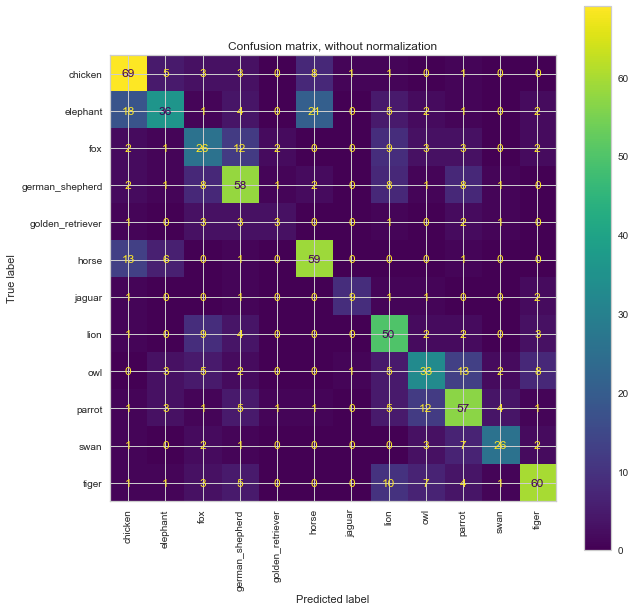

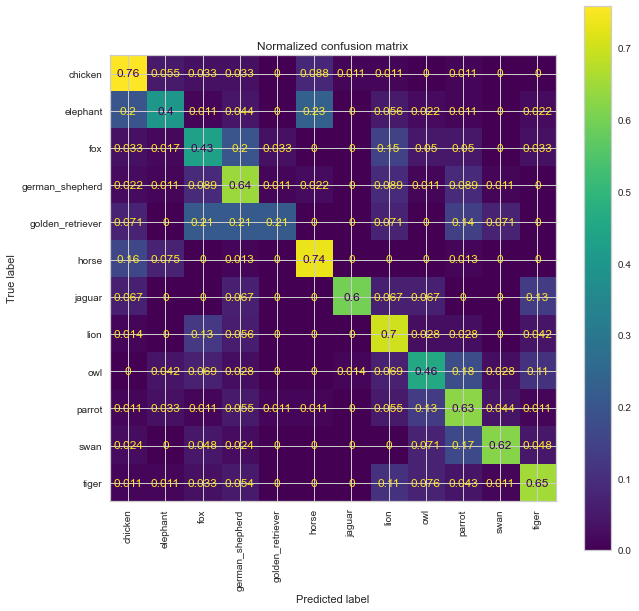

In [99]:
print("current log loss: " + str(acc_rf))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = plot_confusion_matrix(eclf, X_arr, Y_arr,
                                 display_labels=label_strings,
                                 xticks_rotation='vertical',
                                 normalize=normalize , ax = ax)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    

plt.show()

In [61]:
from sklearn.ensemble import StackingClassifier
test_data = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data.append(bow_feature_vector)
    
    
X = train_data
Y = train_labels
X, X_DEV , Y , Y_DEV = train_test_split(X,Y,test_size = 0.5,random_state=42) #0.8 split gave us optimal results!
#X = SelectKBest(chi2, k =  1920).fit_transform(X,Y)
#sm = SMOTE(random_state=2)
#X_DEV, Y_DEV = sm.fit_sample(X_DEV, Y_DEV)
X_DEV_arr = np.array(X_DEV)
Y_DEV_arr = np.array(Y_DEV)
X_arr = np.array(X)
Y_arr = np.array(Y)

print(np.shape(X_arr))
models = [('lr',LogisticRegression(C= 8 , max_iter= 2000 )),
          ('svm',SVC(C=100 , gamma = 0.01 , probability = True)),
          ('xgb' , XGBClassifier(objective = "multi:softprob",
                        eval_metric = "mlogloss",
                        colsample_bytree = 0.5,
                        scale_pos_weight = 1,
                        learning_rate = 0.01,
                        reg_alpha = 1e-4,
                        max_depth = 6,
                        min_child_weight = 2,
                        n_estimators = 2048,
                        subsample = 0.8,
                        verbosity = 1))]


eclf = StackingClassifier(estimators=models , cv = 3 , verbose= True , n_jobs = -1)
eclf.fit(X_DEV_arr,Y_DEV_arr)
test_data_arr = np.array(test_data)
Forest_prediction = eclf.predict_proba(test_data_arr)
y_pred=eclf.predict(X_arr)
ada_forrest_train = eclf.predict_proba(X_arr)
acc_rf = log_loss(Y, ada_forrest_train)



(2021, 2000)


Original log loss:
current log_loss: 1.2491224699746701
Clipped log loss with clipping at:0.0025
current log_loss: 1.2491224699746701
Clipped log loss with clipping at:0.005
current log_loss: 1.2491224699746701
Clipped log loss with clipping at:0.01
current log_loss: 1.2491223897761508
Clipped log loss with clipping at:0.02
current log_loss: 1.249121690133735
Clipped log loss with clipping at:0.03
current log_loss: 1.24911908038661
Clipped log loss with clipping at:0.04
current log_loss: 1.2491124394050734
Clipped log loss with clipping at:0.05
current log_loss: 1.2490832862219148
Clipped log loss with clipping at:0.07
current log_loss: 1.249141590821376
Clipped log loss with clipping at:0.1
current log_loss: 1.249137459842513
Clipped log loss with clipping at:0.15
current log_loss: 1.249628737208905
Clipped log loss with clipping at:0.2
current log_loss: 1.2497875865504173
Clipped log loss with clipping at:0.25
current log_loss: 1.2494685776191041
Clipped log loss with clipping at:0.3

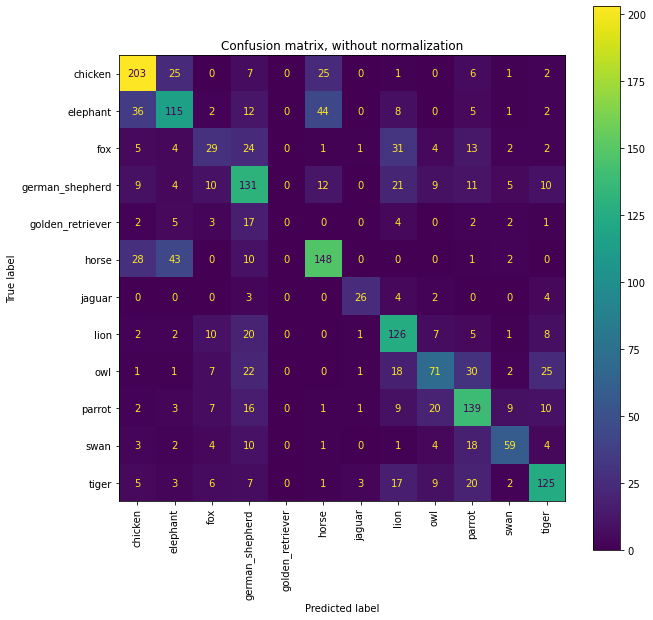

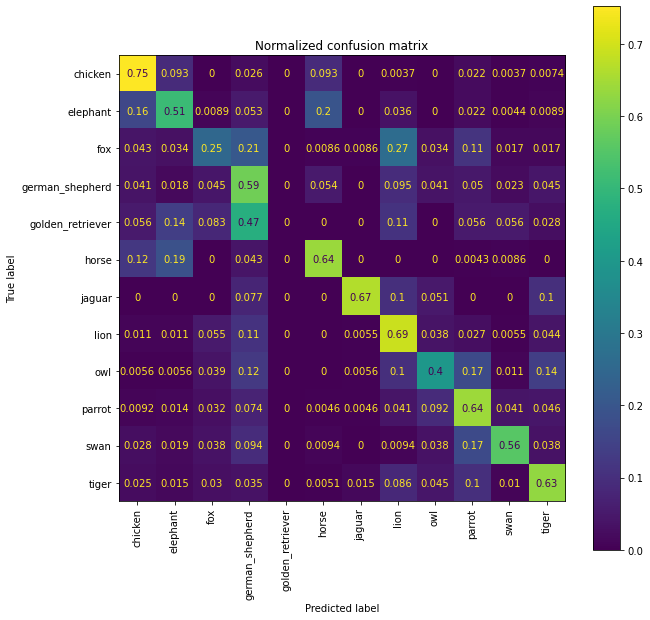

In [62]:
clip_data = [0.0025,0.005 ,0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.07 , 0.10 , 0.15 , 0.20 , 0.25 ,  0.3 , 0.35 , 0.4 , 0.45 , 0.5]


print("Original log loss:")
#ada_forrest_train = logreg_best.predict_proba(X_arr)

print("current log_loss: " + str(acc_rf))
for i in clip_data:
    best_score = 9999999
    print("Clipped log loss with clipping at:" + str(i))
    logistic_regression_train = eclf.predict_proba(X_arr)
    logistic_regression_train[logistic_regression_train > 1-i] = 1
    acc_logreg = log_loss(Y, logistic_regression_train)
    print("current log_loss: " + str(acc_logreg))
    if acc_logreg > best_score:
        best_score = acc_logreg
        best_clip = i

print("--------------------------------------")

for i in clip_data:
    best_score = 9999999
    print("Clipped log loss with clipping at:" + str(i))
    logistic_regression_train = eclf.predict_proba(X_arr)
    logistic_regression_train[logistic_regression_train < i] = 0
    logistic_regression_train[logistic_regression_train > 1-i] = 1    
    acc_logreg = log_loss(Y, logistic_regression_train)
    print("current log_loss: " + str(acc_logreg))
    if acc_logreg > best_score:
        best_score = acc_logreg
        best_clip = i

print("--------------------------------------")


clip_range = [0.0025,0.012 ,0.006 , 0.003 , 0.001 , 0.0001 , 0.00001]
for i in clip_data:
    for j in clip_range:
        best_score = 9999999
        print("Clipped log loss with clipping at:" + str(i))
        logistic_regression_train = eclf.predict_proba(X_arr)
        logistic_regression_train[logistic_regression_train < i] = 0
        logistic_regression_train[logistic_regression_train > 1-i] = 1
        logistic_regeression_train = np.clip(logistic_regression_train , j  , 1-j )
        acc_logreg = log_loss(Y, logistic_regression_train)
        print("current log_loss: " + str(acc_logreg))
        if acc_logreg > best_score:
            best_score = acc_logreg
            best_clip = i
            best_cliprange = j



print("--------------------------------------")


for i in clip_data:
    for j in clip_range:
        best_score = 9999999
        print("Clipped log loss with clipping at:" + str(i))
        logistic_regression_train = eclf.predict_proba(X_arr)
        logistic_regression_train[logistic_regression_train > 1-i] = 1
        logistic_regeression_train = np.clip(logistic_regression_train , j  , 1-j )
        acc_logreg = log_loss(Y, logistic_regression_train)
        print("current log_loss: " + str(acc_logreg))
        if acc_logreg > best_score:
            best_score = acc_logreg
            best_clip = i
            best_cliprange = j



print("--------------------------------------")
 
    

print("current log loss: " + str(acc_rf))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = plot_confusion_matrix(eclf, X_arr, Y_arr,
                                 display_labels=label_strings,
                                 xticks_rotation='vertical',
                                 normalize=normalize , ax = ax)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    

plt.show()

In [26]:
print(voting_class_test_without_smote)
voting_class_test_without_smote = voting_class_test_without_smote / 5
print(voting_class_test_without_smote)

[[5.13847462e-03 8.45369517e-04 1.36204140e-03 ... 1.52295690e-02
  5.38875489e-03 4.95297867e+00]
 [2.72166987e-01 1.21687311e-01 9.40306711e-01 ... 6.84975064e-02
  3.81808291e-02 1.21651702e-02]
 [6.02218649e-02 1.67532176e-01 1.44387214e-03 ... 3.31473200e-03
  1.08073724e-03 1.15238954e-03]
 ...
 [3.14309228e-02 1.87935814e+00 1.85671913e-02 ... 3.76957199e-02
  7.01043012e-01 6.93402156e-03]
 [2.81768566e-03 1.80586045e-02 6.78164173e-01 ... 1.41177148e-02
  7.65969718e-03 1.17590923e-01]
 [8.11984673e-03 2.51562012e-02 7.72342482e-01 ... 7.00000810e-02
  2.57839553e-02 9.02356665e-01]]
[[1.02769492e-03 1.69073903e-04 2.72408280e-04 ... 3.04591381e-03
  1.07775098e-03 9.90595735e-01]
 [5.44333974e-02 2.43374622e-02 1.88061342e-01 ... 1.36995013e-02
  7.63616582e-03 2.43303405e-03]
 [1.20443730e-02 3.35064352e-02 2.88774427e-04 ... 6.62946401e-04
  2.16147448e-04 2.30477907e-04]
 ...
 [6.28618456e-03 3.75871627e-01 3.71343826e-03 ... 7.53914399e-03
  1.40208602e-01 1.38680431e-03]

In [27]:
# Build a submission




pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('voting_class_test_without_smote', 'csv'))
helpers.writePredictionsToCsv(voting_class_test_without_smote, pred_file_path, label_strings)